In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from scipy.spatial.distance import pdist, cdist
import scipy

from tqdm import tqdm

import umap.umap_ as umap

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Prepare Data as HDF5 File

In [28]:
# %%
# raw data path (csv)
# root = r'./Small LCL Data'
root = r'D:\LSM_data_set'
# name of the hdf5 output file
file_out = 'D:\LSM_data_set\londonSmartMeter.h5'

if not os.path.isfile(file_out):
  hdf = pd.HDFStore(file_out, mode='a')
  # %%
  for file_nr in range(5): # TODO: replace 5 with 168 --> than all files will be used
      csv_file_path = root + os.sep + 'LCL-June2015v2_'+str(file_nr)+'.csv'
      df = pd.read_csv(csv_file_path, delimiter=',', decimal='.',
                      na_values='Null', infer_datetime_format=True, parse_dates=['DateTime'])

      df.set_index('DateTime', inplace=True)
      df.columns = ['KWH_per_hald_hour' if s=='KWH/hh (per half hour) ' else s for s in df.columns]
      # list of unique household IDs
      LCLid_list = list(df['LCLid'].unique())
      print(f'{file_nr = }, {LCLid_list[0] = }, {LCLid_list[-1] = }')
      for LCLid in LCLid_list:
          df_sgl = df[df['LCLid']==LCLid]
          hdf.put(key=LCLid, value=df_sgl, format='table', append=True, data_columns=True)

  # %%

  key = hdf.keys()
  df = hdf.get(key[1])
  # df.plot()
  # plt.show()

  df = hdf.get(key[2])
  # df.plot()
  # plt.show()
  # %%

  hdf.close()
else: 
  print('HDF5 file exists')



HDF5 file exists


# Experiment Setup

* Trainingszeitraum ist alles vor dem 01.01.2013 00:00 Uhr
* Testzeitraum ist alles nach dem 01.01.2013 00:00 Uhr
* Test-Haushalte sind die ersten 120 Haushalte sortiert nach MAC Nummer
 * Im Training dürfen prinzipiell alle Hashalte verwendet werden --> sollte jedoch angegeben werden, wie viele und welche es genau waren
 * Szenario 1: nur die 120 ersten Haushalte werden zum Training verwendet
 * Szenario 2: alle Haushalte werden verwendet
 * 75% der Test-Zeitschritte (Messungen) müssen für einen Haushalt verfügbar sein, dass er in der Auswertung berücksichtigt wird 
* Auswertung auf Basis von MMD, berechnet auf Tagen (48 halbstündliche Zeitschritte, beginnend um 00:00 Uhr --> Anzahl Samples, entspricht Anzahl Tage je Haushalt)
* Vergleich zwischen zwei Methoden durch T-Test / Whitney-U Test über die Menge der Test-Haushalt-MMDs im Testzeitraum
* Außerdem mittlere Profile aus real und fake-Daten mit RMSE vergleichen


In [29]:
# first MAC number to be considered
start_mac = 2
# number of households
n_households = 120
# start date of the test period
test_start_date = np.datetime64("2013-01-01 00:00")
# minimum required ratio of available test time steps 
min_test_required = 0.75

# Prepare Training & Test Data

In [30]:
def filter_households(data : dict, min_test_required : float=.75) -> dict():
  """
  filter_households(data, min_test_required) removes all households from data, 
  where not enough test-samples are provided. E.g.
    data_filtered = filter_households(data, 0.5)
  would require, that 50% of all test time steps are available.
  """
  n_samples_test = []
  for household in data:
    n_samples_test.append(len(household['power_test']))
  max_num_time_steps = max(n_samples_test)
  min_abs_required = max_num_time_steps*min_test_required
  data_filtered = []
  for k, household in enumerate(data):
    if n_samples_test[k] > min_abs_required:
      data_filtered.append(household)
  return data_filtered

def load_households_from_hdf(hdf_file, start_mac, n_households, min_test_required):
  # first MAC number not to be considered
  end_mac = start_mac + n_households 
  keys = [f'/MAC{k:06}' for k in range(start_mac, end_mac)]
  data = []
  with pd.HDFStore(hdf_file, mode='r') as hdf:
    for key_id, key in tqdm(enumerate(keys)):

      if key in hdf:
        df = hdf.get(key)
        df = df.resample('30min').mean()
        df.dropna(inplace=True)
        # from pandas to numpy floats
        power_values = df['KWH_per_hald_hour'].values.astype(np.float32)
        time = df.index.values # np.datetime64
        train_bool = time < test_start_date
        train_idx = np.where(train_bool)[0]
        test_idx = np.where(np.logical_not(train_bool))[0]

        power_train = power_values[train_idx]
        power_test = power_values[test_idx]
        time_train = time[train_idx]
        time_test = time[test_idx]
        data.append(dict(
            key = key,
            power_train = power_train,
            power_test = power_test,
            time_train = time_train,
            time_test = time_test
        ))

    hdf.close()
  data = filter_households(data, min_test_required)
  return data

data = load_households_from_hdf(
    hdf_file=file_out, 
    start_mac=start_mac, 
    n_households=n_households,
    min_test_required=min_test_required
)
print("\nNumber of households:", len(data))

120it [00:04, 25.60it/s]


Number of households: 109


Text(0, 0.5, 'Household Nr. + power [4*kWh]')

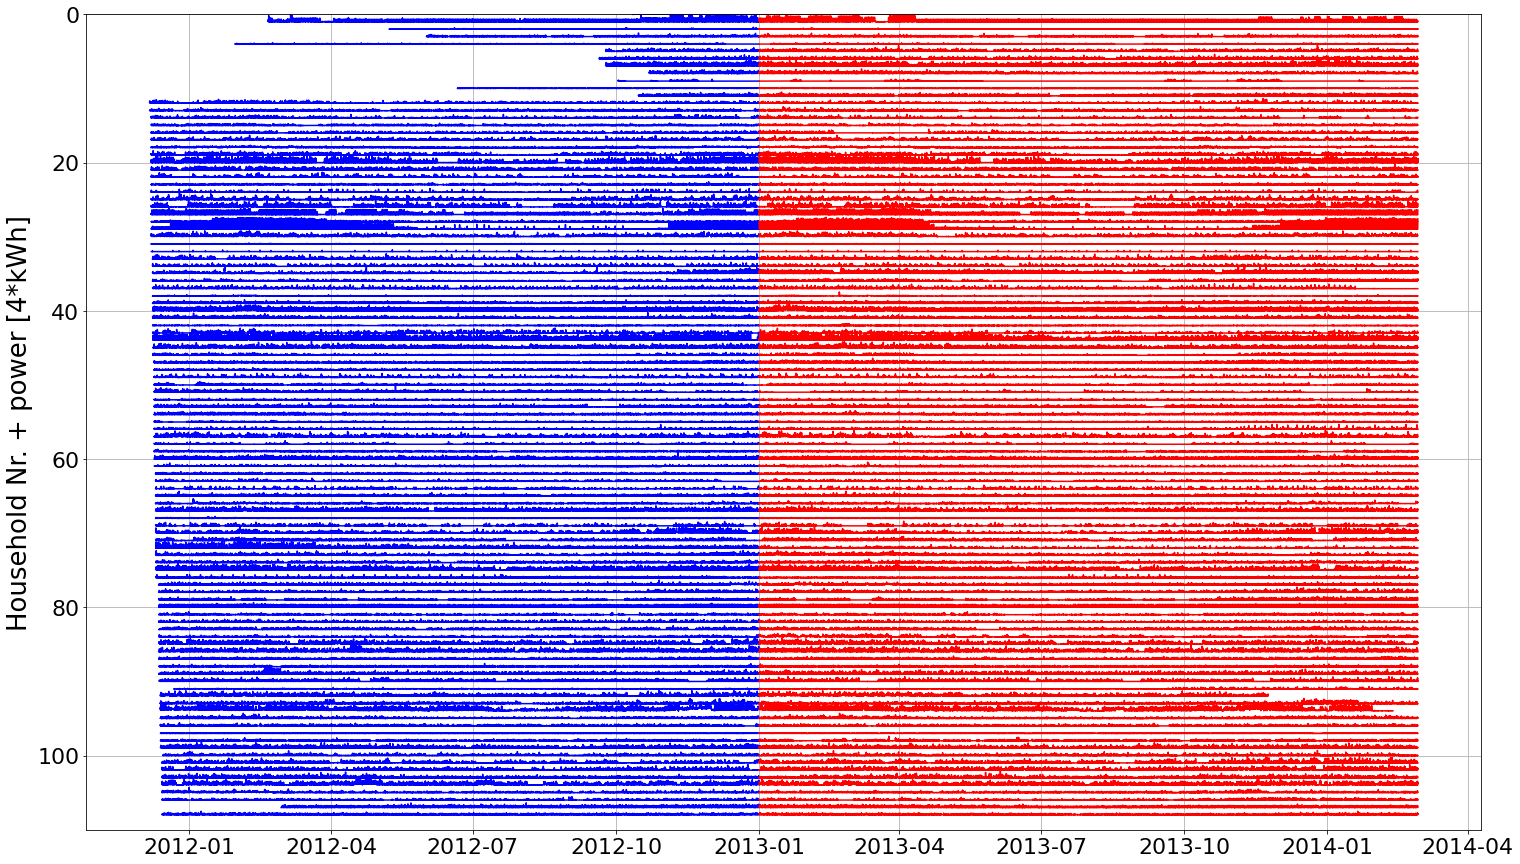

In [31]:
plt.figure(figsize=(25,15))
for k in range(len(data)):
  plt.plot(data[k]['time_train'], data[k]['power_train']/-4 + k,'b-')
  plt.plot(data[k]['time_test'], data[k]['power_test']/-4 + k,'r-')
#plt.title('Overview of Training (blue) and Test (red) Data', fontsize=26)
#plt.xlabel('Date [yyyy-mm]',fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True)
plt.ylim(110,0)
plt.ylabel('Household Nr. + power [4*kWh]',fontsize=26)

In [32]:
def timeseries_to_day_matrix(time, power, return_time_mat=False, drop_na=True):
  """
  Reshapes time series into a matrix, where each column corresponds to 
  time of day and each row correspnds to a day
  X_train = timeseries_to_day_matrix(time_train, power_train)
  X_test = timeseries_to_day_matrix(time_test, power_test)
  """
  df = pd.DataFrame(dict(time=time, power=power))
  df.set_index('time', inplace=True)
  df = df.resample('30min').mean()
  min_date = np.min(df.index)
  bool_idx = df.index >= (np.datetime64(f'{min_date.year}-{min_date.month:02.0f}-{min_date.day:02.0f}') + 1)
  max_date = np.max(df.index)
  bool_idx = np.logical_and(bool_idx, 
    (df.index < np.datetime64(f'{max_date.year}-{max_date.month:02.0f}-{max_date.day:02.0f}') - 1))
  df = df[bool_idx]
  power_mat = df['power'].values.reshape(-1,48)
  time_mat = df.index.values.reshape(-1,48)
  if drop_na:
    keep_idx = np.logical_not(np.any(np.isnan(power_mat), axis=1))
    power_mat = power_mat[keep_idx]
    time_mat = time_mat[keep_idx]

  if return_time_mat:
    return power_mat, time_mat
  else:
    return power_mat

# Train Generative Models

In [33]:
class ModelTemplate(object):
  def __init__(self):
    pass
  
  def train(self, data):
    pass
  
  def sample(self, data, n_samples):
    pass

class MultivariateNormal(ModelTemplate):
  def __init__(self):
    self.mdl_dict = dict()
  
  def train(self, data):
    self.mdl_dict
    for household in tqdm(data):
      key = household['key']
      time_train = household['time_train']
      power_train = household['power_train']
      X_train = timeseries_to_day_matrix(time_train, power_train)
      mu = np.mean(X_train, axis=0)
      covMat = np.cov(X_train.T)
      self.mdl_dict[key] = dict(mu=mu, covMat=covMat)
  
  def sample(self, data):
    results = dict()
    for household in tqdm(data):
      key = household['key']
      time_test = household['time_test']
      power_test = household['power_test']
      _, time_mat = timeseries_to_day_matrix(time_test, power_test, return_time_mat=True)
      mu = self.mdl_dict[key]['mu']
      covMat = self.mdl_dict[key]['covMat']
      results[key] = dict()
      results[key]['samples'] = np.random.multivariate_normal(mean=mu, cov=covMat, size=(time_mat.shape[0],)).reshape(-1)
      results[key]['times'] = time_mat.reshape(-1)
    return results

In [34]:
class GaussianMixtureModel(ModelTemplate):
  def __init__(self):
    self.mdl_dict = dict()
  
  def train(self, data):
    self.mdl_dict
    for household in tqdm(data):
      key = household['key']
      time_train = household['time_train']
      power_train = household['power_train']
      X_train = timeseries_to_day_matrix(time_train, power_train)
      mdl = GaussianMixture(n_components=5)
      mdl.fit(X_train)
      self.mdl_dict[key] = mdl

  def sample(self, data):
    results = dict()
    for household in tqdm(data):
      key = household['key']
      time_test = household['time_test']
      power_test = household['power_test']
      _, time_mat = timeseries_to_day_matrix(time_test, power_test, return_time_mat=True)
      mdl = self.mdl_dict[key]
      X_fake = mdl.sample(n_samples=time_mat.shape[0])[0]
      results[key] = dict()
      results[key]['samples'] = X_fake.reshape(-1)
      results[key]['times'] = time_mat.reshape(-1)
    return results



100%|██████████| 109/109 [00:00<00:00, 116.72it/s]

20112


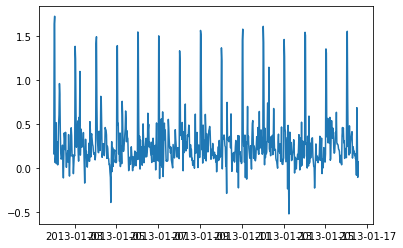

In [35]:
mdl = GaussianMixtureModel()
mdl.train(data)
gmm_samples = mdl.sample(data)

plt.plot(gmm_samples['/MAC000003']['times'][:700].T, gmm_samples['/MAC000003']['samples'][:700].T)
print(len(gmm_samples['/MAC000003']['samples']))

100%|██████████| 109/109 [00:00<00:00, 238.34it/s]


20112


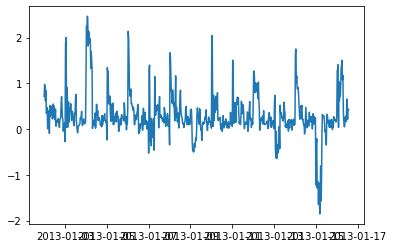

In [36]:
mdl = MultivariateNormal()
mdl.train(data)
mvn_samples = mdl.sample(data)

plt.plot(mvn_samples['/MAC000003']['times'][:700].T, mvn_samples['/MAC000003']['samples'][:700].T)
print(len(mvn_samples['/MAC000003']['samples']))

In [37]:
mvn_samples

{'/MAC000002': {'samples': array([0.40765226, 0.350089  , 0.33391863, ..., 0.27018479, 0.28289499,
         0.30860828]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([ 0.71389355,  0.9751114 ,  0.89834146, ..., -0.04816998,
          0.13513384,  0.02243903]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([ 0.10555866,  0.09341246,  0.09663968, ...,  0.02132157,
         -0.00162382,  0.00538686]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.

# Transforms data frame 

- with columns time,MAC_IDs.... und datetime64,kwh_hh values into a tensor for the analysis in this notebook


In [38]:
# WGAN_df
# print(WGAN_df['Datetime'].dtype)

In [40]:
#WGAN_df

In [43]:
WGAN_df = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Ben\WGAN.csv', index_col=0)
WGAN_df['Datetime'] = WGAN_df['Datetime'].astype('datetime64[ns]')

WGAN_samples = dict()

for col in WGAN_df:
  if col != 'Datetime':
    key = f'/{col}'
    WGAN_samples[key] = dict()
    WGAN_samples[key]['samples'] = WGAN_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    WGAN_samples[key]['times'] = WGAN_df['Datetime'].values

WGAN_samples

{'/MAC000002': {'samples': array([0.01304061, 0.01168355, 0.03243039, ..., 0.01638033, 0.01331919,
         0.01457999]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',
         '2013-01-03T01:00:00.000000000', ...,
         '2014-03-30T22:30:00.000000000', '2014-03-30T23:00:00.000000000',
         '2014-03-30T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([0.01857736, 0.00999029, 0.00729388, ..., 0.02553611, 0.01880656,
         0.0138304 ]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',
         '2013-01-03T01:00:00.000000000', ...,
         '2014-03-30T22:30:00.000000000', '2014-03-30T23:00:00.000000000',
         '2014-03-30T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([0.01124787, 0.01087739, 0.00843449, ..., 0.00476069, 0.00538103,
         0.01445116]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',


In [44]:
#CNN_VAE_df

In [46]:
#CNN_VAE_df = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Ben\CNNVAE.csv',index_col=0)
CNN_VAE_df = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Ben\CNNVAE.csv',index_col=0)
CNN_VAE_df = CNN_VAE_df.drop(columns='Datetime')
CNN_VAE_df = CNN_VAE_df.rename(columns={'Datetime.1':'Datetime'})
CNN_VAE_df['Datetime'] = CNN_VAE_df['Datetime'].astype('datetime64[ns]')
CNN_VAE_df
print(CNN_VAE_df['Datetime'].dtype)
CNN_VAE_samples = dict()

for col in CNN_VAE_df:
  if col != 'Datetime':
    key = f'/{col}'
    CNN_VAE_samples[key] = dict()
    CNN_VAE_samples[key]['samples'] = CNN_VAE_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    CNN_VAE_samples[key]['times'] = CNN_VAE_df['Datetime'].values

CNN_VAE_samples

datetime64[ns]


{'/MAC000002': {'samples': array([0.01530163, 0.01489763, 0.01258588, ..., 0.0170732 , 0.01477619,
         0.01556897]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',
         '2013-01-03T01:00:00.000000000', ...,
         '2014-03-30T22:30:00.000000000', '2014-03-30T23:00:00.000000000',
         '2014-03-30T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([0.01191463, 0.01243742, 0.01074685, ..., 0.06272171, 0.04865068,
         0.04098263]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',
         '2013-01-03T01:00:00.000000000', ...,
         '2014-03-30T22:30:00.000000000', '2014-03-30T23:00:00.000000000',
         '2014-03-30T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([0.03541794, 0.03084932, 0.02448741, ..., 0.0459767 , 0.03627291,
         0.03334124]),
  'times': array(['2013-01-03T00:00:00.000000000', '2013-01-03T00:30:00.000000000',


In [47]:

#ddpm_df

NameError: name 'ddpm_df' is not defined

In [ ]:
#ddpm_df = ddpm_df.reset_index()



In [ ]:
#ddpm_df

Datetime  MAC000002  MAC000003  MAC000004  MAC000005  \
0     2013-01-01 00:00:00   0.067420   0.080322  -0.002865  -0.047484   
1     2013-01-01 00:30:00   0.053140   0.014795  -0.006067   0.059896   
2     2013-01-01 01:00:00   0.029706   0.020383  -0.036720   0.037693   
3     2013-01-01 01:30:00  -0.006290  -0.012551  -0.017072   0.098691   
4     2013-01-01 02:00:00   0.032831   0.004596   0.005521   0.058580   
...                   ...        ...        ...        ...        ...   
20347 2014-02-28 21:30:00   0.102509   0.002292   0.032142   0.393386   
20348 2014-02-28 22:00:00   0.039428  -0.021463  -0.004615   0.356722   
20349 2014-02-28 22:30:00   0.062741   0.029875   0.006180   0.259226   
20350 2014-02-28 23:00:00  -0.012550   0.014140   0.053635   0.259016   
20351 2014-02-28 23:30:00   0.046992  -0.012560   0.105175   0.040386   

       MAC000006  MAC000007  MAC000008  MAC000009  MAC000010  ...  MAC000112  \
0       0.064245  -0.003134   0.045826   0.076037   0.009144  ...   0.056649   
1       0.027715   0.054604   0.014546   0.092486  -0.032948  ...   0.044801   
2       0.018232  -0.028666   0.011225   0.128190   0.037618  ...   0.007516   
3      -0.003544   0.027880  -0.063877   0.343711  -0.000833  ...   0.014051   
4       0.005185   0.070510  -0.020258   0.046926   0.034290  ...  -0.004594   
...          ...        ...        ...        ...        ...  ...        ...   
20347   0.061113   0.413212   0.151268   0.006450   0.122131  ...   0.122722   
20348   0.045961   0.249953   0.087917   0.004822   0.143054  ...   0.166320   
20349   0.061131   0.159731   0.061148  -0.030817   0.153414  ...   0.131893   
20350   0.013663   0.091630   0.310418  -0.009954   0.179283  ...   0.027640   
20351  -0.002241   0.095941   0.116784   0.011655   0.118686  ...   0.008301   

       MAC000113  MAC000114  MAC000115  MAC000116  MAC000117  MAC000118  \
0       0.009668  -0.006702   0.046000   0.032277   0.248017   0.057598   
1      -0.008800   0.039724   0.025413  -0.008878   0.228073   0.116511   
2       0.028318   0.042492   0.087931  -0.082203   0.181341   0.139639   
3      -0.043156   0.001167  -0.068196  -0.000119   0.119952   0.091031   
4       0.004414   0.016620   0.004299  -0.009794   0.230452   0.033162   
...          ...        ...        ...        ...        ...        ...   
20347  -0.015135   0.478508   0.112328   0.255490   0.046195   0.128983   
20348   0.030122   0.783282   0.140514   0.155778   0.030352   0.166492   
20349   0.090961   0.407672   0.103549   0.105793   0.038792   0.056724   
20350   0.030104   0.080939   0.143890   0.059393   0.042979   0.112271   
20351  -0.008192   0.119933   0.063134  -0.023080   0.135879   0.032000   

       MAC000119  MAC000120  MAC000121  
0       0.009392  -0.042696   0.019072  
1       0.097937  -0.037835   0.153206  
2       0.101267  -0.011266   0.102286  
3       0.021088   0.044913   0.067427  
4       0.042726   0.032650   0.008709  
...          ...        ...        ...  
20347   0.066723   0.153019   0.157208  
20348   0.062746   0.113405   0.106212  
20349   0.027501   0.026874   0.049819  
20350   0.009321   0.100661   0.106908  
20351   0.079107   0.049367   0.126246  

[20352 rows x 121 columns]

In [48]:
ddpm_df = pd.read_csv('D:\LSM_data_set\DDPM_syn.csv')
ddpm_df['Datetime'] = ddpm_df['Datetime'].astype('datetime64[ns]')
ddpm_df
ddpm_samples = dict()

for col in ddpm_df:
  if col != 'Datetime':
    key = f'/{col}'
    ddpm_samples[key] = dict()
    ddpm_samples[key]['samples'] = ddpm_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    ddpm_samples[key]['times'] = ddpm_df['Datetime'].values

ddpm_samples

{'/MAC000002': {'samples': array([ 0.06742022,  0.05313999,  0.02970627, ...,  0.0627407 ,
         -0.01254977,  0.04699219]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',
         '2013-01-01T01:00:00.000000000', ...,
         '2014-02-28T22:30:00.000000000', '2014-02-28T23:00:00.000000000',
         '2014-02-28T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([ 0.08032236,  0.01479491,  0.02038345, ...,  0.02987543,
          0.01413992, -0.01255989]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',
         '2013-01-01T01:00:00.000000000', ...,
         '2014-02-28T22:30:00.000000000', '2014-02-28T23:00:00.000000000',
         '2014-02-28T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([-0.00286533, -0.00606745, -0.03671998, ...,  0.00618037,
          0.0536353 ,  0.1051752 ]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:

In [50]:
#hmm_df

In [51]:
hmm_df = pd.read_csv('D:\LSM_data_set\HMM_syn2.csv', index_col=0)

hmm_samples = dict()
for col in hmm_df:
  if col != 'Datetime':
    key = f'/{col}'
    hmm_samples[key] = dict()
    hmm_samples[key]['samples'] = hmm_df[col].values
    hmm_samples[key]['times'] = hmm_df['Datetime'].values.astype('datetime64[ns]')

hmm_samples

{'/MAC000002': {'samples': array([0.84820886, 1.21433385, 0.10377143, ..., 0.16684374, 0.11096447,
         0.07770017]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',
         '2013-01-01T01:00:00.000000000', ...,
         '2014-01-02T22:30:00.000000000', '2014-01-02T23:00:00.000000000',
         '2014-01-02T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([0.84820886, 1.21433385, 0.10377143, ..., 0.16684374, 0.11096447,
         0.07770017]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',
         '2013-01-01T01:00:00.000000000', ...,
         '2014-01-02T22:30:00.000000000', '2014-01-02T23:00:00.000000000',
         '2014-01-02T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([0.04316331, 0.06690677, 0.05083487, ..., 0.04364961, 0.03435109,
         0.02881578]),
  'times': array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:30:00.000000000',


In [53]:
#con_bnf_df

In [54]:
con_bnf_df = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Marcel\con_BNF.csv', index_col=0)
con_bnf_df = con_bnf_df.rename(columns={'datetime':'Datetime'})
con_bnf_df['Datetime'] = con_bnf_df['Datetime'].astype('datetime64[ns]')
con_bnf_df['MAC000005'] = con_bnf_df['MAC000004']
con_bnf_df['MAC000008'] = con_bnf_df['MAC000009']
con_bnf_df['MAC000014'] = con_bnf_df['MAC000018']
con_bnf_df['MAC000015'] = con_bnf_df['MAC000018']
con_bnf_df['MAC000016'] = con_bnf_df['MAC000018']
con_bnf_df['MAC000017'] = con_bnf_df['MAC000018']
con_bnf_df['MAC000028'] = con_bnf_df['MAC000029']
con_bnf_df['MAC000031'] = con_bnf_df['MAC000032']
con_bnf_df['MAC000044'] = con_bnf_df['MAC000045']
con_bnf_df['MAC000046'] = con_bnf_df['MAC000047']
con_bnf_df['MAC000048'] = con_bnf_df['MAC000049']
con_bnf_df['MAC000050'] = con_bnf_df['MAC000055']
con_bnf_df['MAC000051'] = con_bnf_df['MAC000055']
con_bnf_df['MAC000052'] = con_bnf_df['MAC000055']
con_bnf_df['MAC000063'] = con_bnf_df['MAC000066']
con_bnf_df['MAC000064'] = con_bnf_df['MAC000066']
con_bnf_df['MAC000065'] = con_bnf_df['MAC000066']
con_bnf_df['MAC000071'] = con_bnf_df['MAC000072']
con_bnf_df['MAC000075'] = con_bnf_df['MAC000077']
con_bnf_df['MAC000076'] = con_bnf_df['MAC000077']
con_bnf_df['MAC000076'] = con_bnf_df['MAC000077']
con_bnf_df['MAC000080'] = con_bnf_df['MAC000081']
con_bnf_df['MAC000082'] = con_bnf_df['MAC000081']
con_bnf_df['MAC000088'] = con_bnf_df['MAC000089']
con_bnf_df['MAC000095'] = con_bnf_df['MAC000096']
con_bnf_df['MAC000106'] = con_bnf_df['MAC000108']
con_bnf_df['MAC000107'] = con_bnf_df['MAC000108']
con_bnf_df['MAC000107'] = con_bnf_df['MAC000110']
con_bnf_df['MAC000109'] = con_bnf_df['MAC000110']
con_bnf_df['MAC000114'] = con_bnf_df['MAC000110']
con_bnf_df['MAC000120'] = con_bnf_df['MAC000121']
con_bnf_samples = dict()

for col in con_bnf_df:
  if col != 'Datetime':
    key = f'/{col}'
    con_bnf_samples[key] = dict()
    con_bnf_samples[key]['samples'] = con_bnf_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    con_bnf_samples[key]['times'] = con_bnf_df['Datetime'].values

con_bnf_samples

{'/MAC000002': {'samples': array([0.14467289, 2.0577304 , 1.9777018 , ..., 0.22242889, 0.27485266,
         0.02658012]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([ 0.6274353 ,  2.584388  ,  0.8502837 , ...,  0.10192428,
          0.26296997, -0.00579451]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([0.08293932, 0.09418703, 0.14632332, ..., 0.3250854 , 0.2609433 ,
         0.06065549]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000

In [56]:
#con_bnf_df2

In [57]:
con_bnf_df2 = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Marcel\con_MAF_BNF.csv', index_col=0)
con_bnf_df2 = con_bnf_df.rename(columns={'datetime':'Datetime'})
con_bnf_df2['Datetime'] = con_bnf_df2['Datetime'].astype('datetime64[ns]')
con_bnf_df2['MAC000005'] = con_bnf_df2['MAC000004']
con_bnf_df2['MAC000008'] = con_bnf_df2['MAC000009']
con_bnf_df2['MAC000014'] = con_bnf_df2['MAC000018']
con_bnf_df2['MAC000015'] = con_bnf_df2['MAC000018']
con_bnf_df2['MAC000016'] = con_bnf_df2['MAC000018']
con_bnf_df2['MAC000017'] = con_bnf_df2['MAC000018']
con_bnf_df2['MAC000028'] = con_bnf_df2['MAC000029']
con_bnf_df2['MAC000031'] = con_bnf_df2['MAC000032']
con_bnf_df2['MAC000044'] = con_bnf_df2['MAC000045']
con_bnf_df2['MAC000046'] = con_bnf_df2['MAC000047']
con_bnf_df2['MAC000048'] = con_bnf_df2['MAC000049']
con_bnf_df2['MAC000050'] = con_bnf_df2['MAC000055']
con_bnf_df2['MAC000051'] = con_bnf_df2['MAC000055']
con_bnf_df2['MAC000052'] = con_bnf_df2['MAC000055']
con_bnf_df2['MAC000063'] = con_bnf_df2['MAC000066']
con_bnf_df2['MAC000064'] = con_bnf_df2['MAC000066']
con_bnf_df2['MAC000065'] = con_bnf_df2['MAC000066']
con_bnf_df2['MAC000071'] = con_bnf_df2['MAC000072']
con_bnf_df2['MAC000075'] = con_bnf_df2['MAC000077']
con_bnf_df2['MAC000076'] = con_bnf_df2['MAC000077']
con_bnf_df2['MAC000076'] = con_bnf_df2['MAC000077']
con_bnf_df2['MAC000080'] = con_bnf_df2['MAC000081']
con_bnf_df2['MAC000082'] = con_bnf_df2['MAC000081']
con_bnf_df2['MAC000088'] = con_bnf_df2['MAC000089']
con_bnf_df2['MAC000095'] = con_bnf_df2['MAC000096']
con_bnf_df2['MAC000106'] = con_bnf_df2['MAC000108']
con_bnf_df2['MAC000107'] = con_bnf_df2['MAC000108']
con_bnf_df2['MAC000107'] = con_bnf_df2['MAC000110']
con_bnf_df2['MAC000109'] = con_bnf_df2['MAC000110']
con_bnf_df2['MAC000114'] = con_bnf_df2['MAC000110']
con_bnf_df2['MAC000120'] = con_bnf_df2['MAC000121']
con_bnf_samples2 = dict()

for col in con_bnf_df2:
  if col != 'Datetime':
    key = f'/{col}'
    con_bnf_samples2[key] = dict()
    con_bnf_samples2[key]['samples'] = con_bnf_df2[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    con_bnf_samples2[key]['times'] = con_bnf_df2['Datetime'].values

con_bnf_samples2

{'/MAC000002': {'samples': array([0.14467289, 2.0577304 , 1.9777018 , ..., 0.22242889, 0.27485266,
         0.02658012]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000003': {'samples': array([ 0.6274353 ,  2.584388  ,  0.8502837 , ...,  0.10192428,
          0.26296997, -0.00579451]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000000',
         '2013-01-02T01:00:00.000000000', ...,
         '2014-02-26T22:30:00.000000000', '2014-02-26T23:00:00.000000000',
         '2014-02-26T23:30:00.000000000'], dtype='datetime64[ns]')},
 '/MAC000004': {'samples': array([0.08293932, 0.09418703, 0.14632332, ..., 0.3250854 , 0.2609433 ,
         0.06065549]),
  'times': array(['2013-01-02T00:00:00.000000000', '2013-01-02T00:30:00.000000

In [58]:
# con_bnf_df = pd.read_csv('D:\GWDG\LSM_Challenge\Contest-Marcel\con_BNF.csv', index_col=0)
# con_bnf_df = con_bnf_df.rename(columns={'datetime':'Datetime'})
# con_bnf_df['MAC000005'] = con_bnf_df['MAC000004'] 
# con_bnf_df.columns

In [ ]:
#hmm_df = hmm_df.drop('Unnamed: 0', axis=1)
#hmm_df.to_csv('D:\LSM_data_set\HMM_syn.csv')
hmm_df

# Define Metrics & Evaluation Tools

In [60]:
# Maximum-Mean-Discrepancy
def mmd(x_real, x_fake):
    """
    Calculates the Maximum-Mean-Discrepancy between two tensors, using the (optimal) bandwidth calculated below;
    and a Gaussian kernel.
    Args:
        x_real: tensor of (real) data of shape [n_samples, n_features, seq_len]
        x_fake: tensor of (dake) data of shape [n_samples, n_features, seq_len]
    """

    if (len(x_real.shape)==3):
      n_1, f_1, seq_1 = x_real.shape
      n_2, f_2, seq_2 = x_fake.shape
      x_real = x_real.reshape(n_1, f_1 * seq_1)
      x_fake = x_fake.reshape(n_2, f_2 * seq_2)
    elif (len(x_real.shape)==2):
      n_1, seq_1 = x_real.shape
      n_2, seq_2 = x_fake.shape
    else:
      raise ValueError("Only 2 or 3 dimensional tensors are possible.")

    sigma = optim_bw_mmd(x_real, x_fake)

    xy = np.concatenate([x_real, x_fake], axis=0)  # concatenate: new size [n_1+n_2,-1]
    #print(xy.shape)
    distances = cdist(xy, xy); #torch.cdist(xy, xy, p=2)  # pairwise distances in L^2
    k = np.exp(
        -(distances ** 2) / (2 * sigma ** 2))  # + epsilon * torch.eye(n_1 + n_2)  # 2. for numerical stability
    k_x = k[:n_1, :n_1]
    k_y = k[n_1:, n_1:]
    k_xy = k[:n_1, n_1:]

    mmd_score = k_x.sum() / (n_1 * (n_1 - 1)) + k_y.sum() / (n_2 * (n_2 - 1)) - 2 * k_xy.sum() / (n_1 * n_2)

    return mmd_score

def optim_bw_mmd(x_real, x_fake):
    """
    Finds the optimal bandwidth for calculating the MMD score.
    """
    n_1 = len(x_real)
    n_2 = len(x_fake)
    x_real = x_real.reshape(n_1, -1)
    x_fake = x_fake.reshape(n_2, -1)

    distances = pdist(np.concatenate([x_real, x_fake], axis=0))
    #indx = np.random.permutation(len(distances))[:500]
    indx = np.arange(len(distances))
    sigma = np.median(distances[indx]) / 2

    return sigma


def compute_household_mmd(data, **kwargs):
  results = {mdl_name: [] for mdl_name in kwargs.keys()}
  for household in tqdm(data):
    time_test, power_test = household['time_test'], household['power_test']
    key = household['key']
    X_test = timeseries_to_day_matrix(time_test, power_test)
    for mdl_name, samples in kwargs.items():
      time_fake = samples[key]['times']
      power_fake = samples[key]['samples']
      X_fake = timeseries_to_day_matrix(time_fake, power_fake)
      mmd_value = mmd(X_fake, X_test)
      results[mdl_name].append(mmd_value)
      
  return results


household_mmds = compute_household_mmd(data, 
  GaussianMixtureModel=gmm_samples, 
  BASELINE=mvn_samples,
  HMM=hmm_samples,
  Con_BNF=con_bnf_samples,
  Con_MAF_BNF=con_bnf_samples2,
  DDPM=ddpm_samples,
  CNN_VAE=CNN_VAE_samples,
  WGAN=WGAN_samples  
)

100%|██████████| 109/109 [00:34<00:00,  3.19it/s]


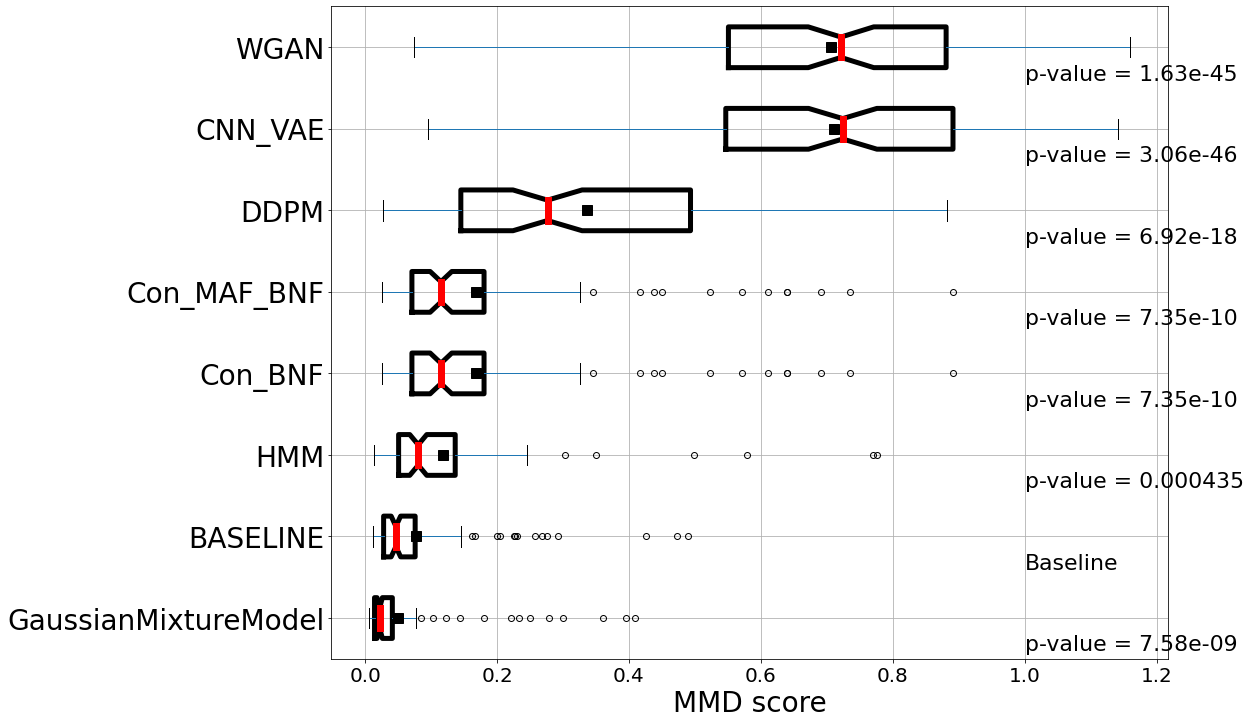

In [61]:
def boxplot_day_mmd(results, baseline_mdl):  
  results_df = pd.DataFrame(results)
  plt.figure(figsize=(15,1.5*len(results.keys())))
  results_df.boxplot(vert=False, notch=True, showmeans=True, meanprops=dict(marker='s', markersize=10, markerfacecolor='black', markeredgecolor='black'), medianprops=dict(linewidth=7, color='red'), widths=0.5, boxprops= dict(linewidth=5))
  plt.xlabel('MMD score', fontsize=28)
  plt.yticks(fontsize=28)
  plt.xticks(fontsize=20)

  for k, mdl_name in enumerate(results.keys()):
    pairwise_differences = np.array(results[baseline_mdl]) - np.array(results[mdl_name])
    if mdl_name != baseline_mdl:
      test_results = scipy.stats.ttest_1samp(pairwise_differences.ravel(), 0, alternative='two-sided')
      plt.text(1, k+0.6, f'p-value = {test_results.pvalue:e<0.3}', fontsize=22)
    else:
      plt.text(1, k+0.6, f'Baseline', fontsize=22)
  #plt.title(f'Boxplot and p-Values of Pairwise two-sided t-Test', fontsize=16)

boxplot_day_mmd(household_mmds, baseline_mdl='BASELINE')


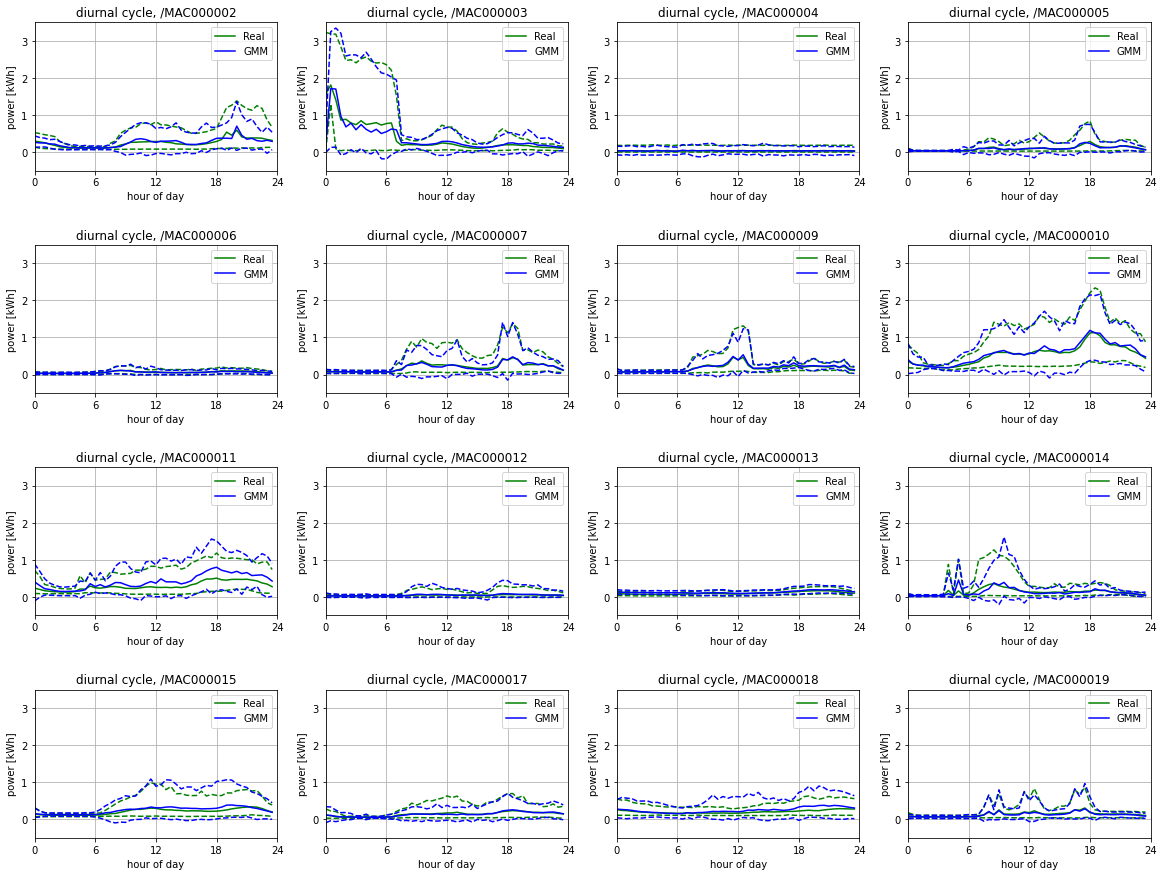

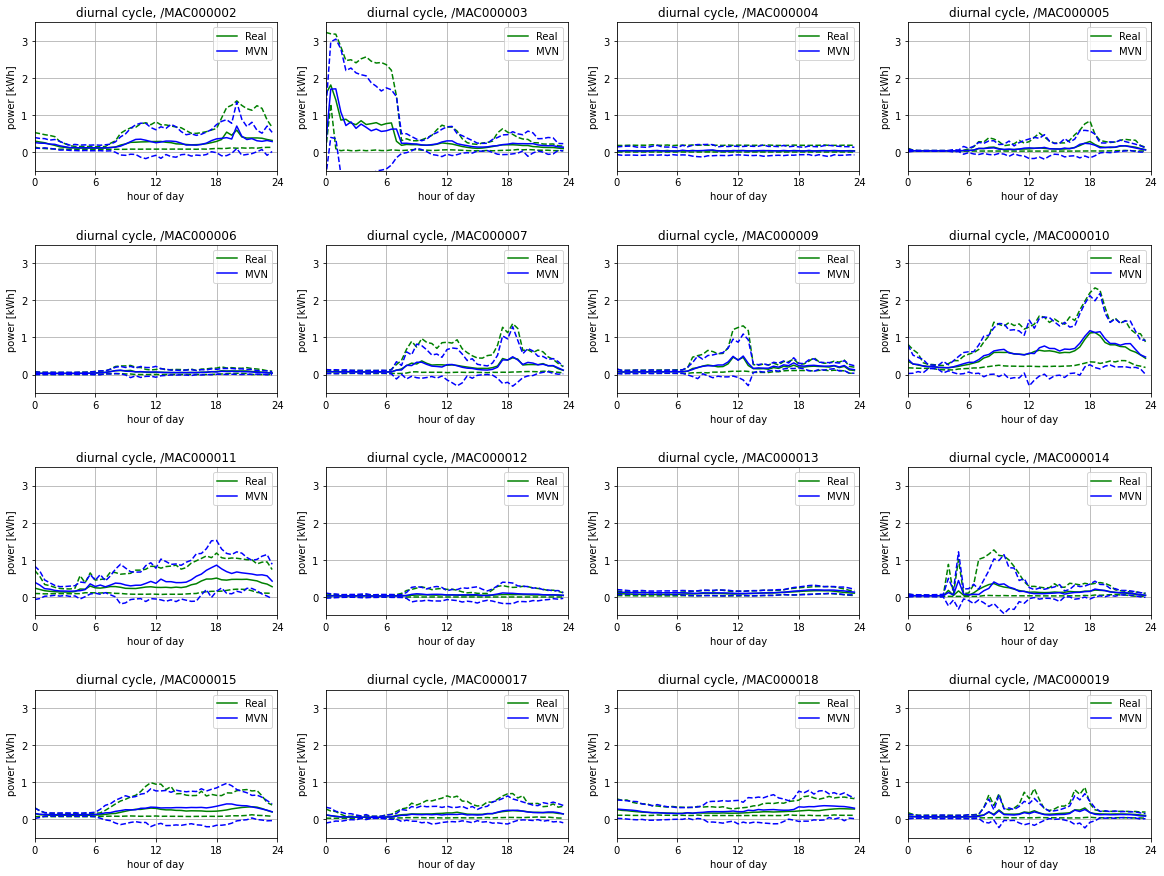

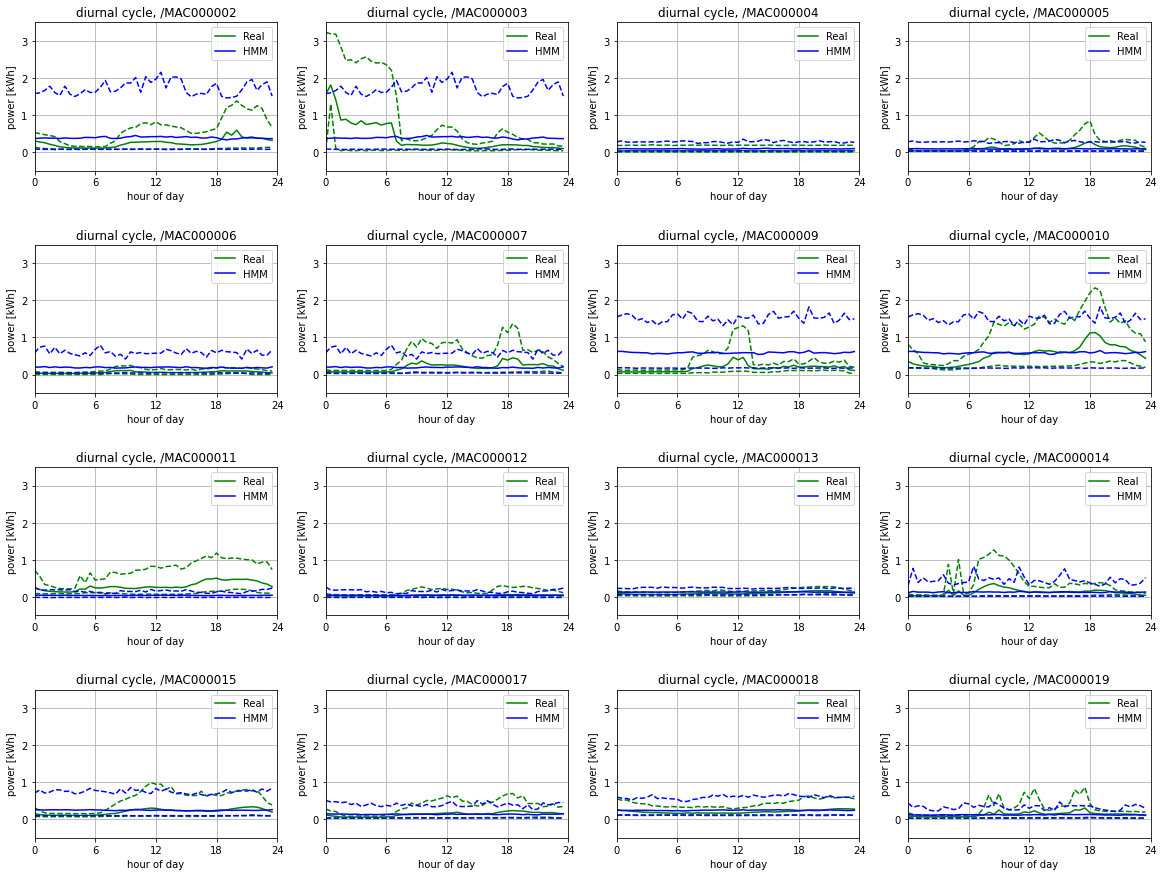

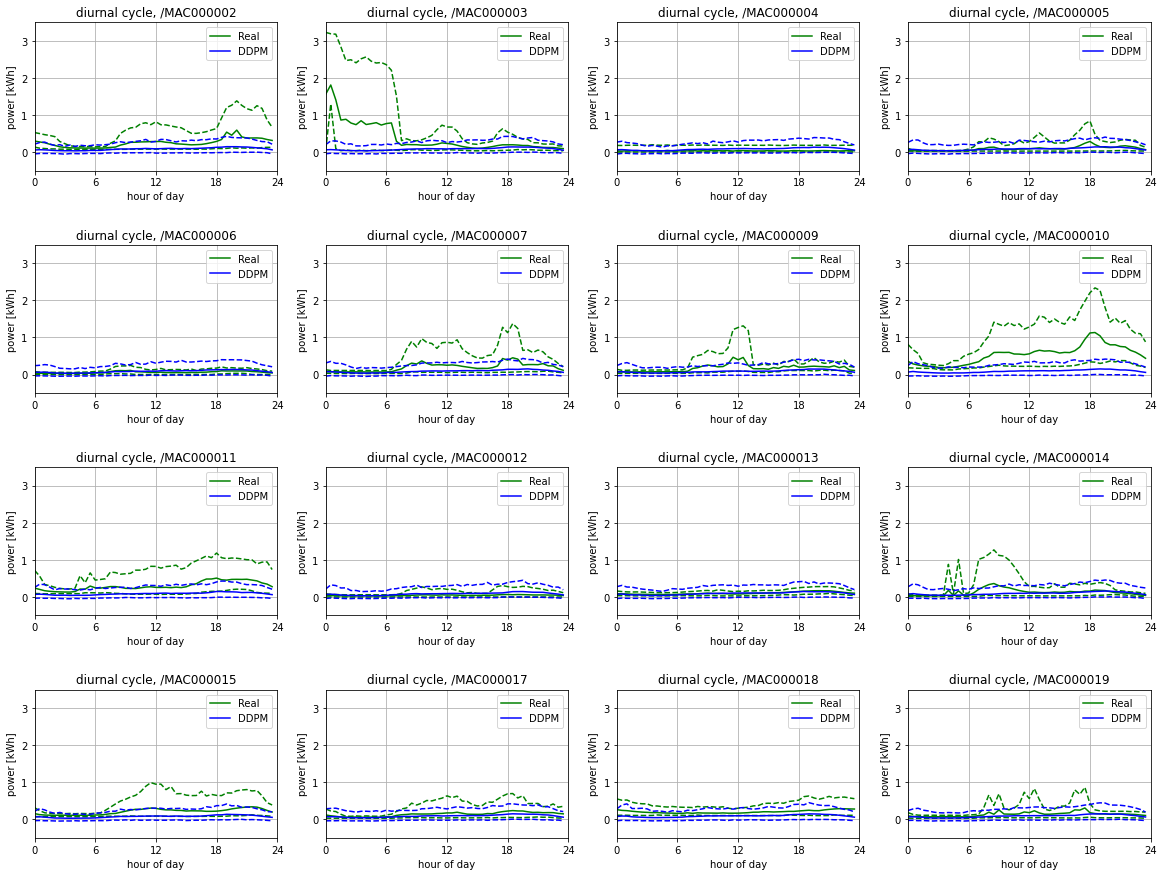

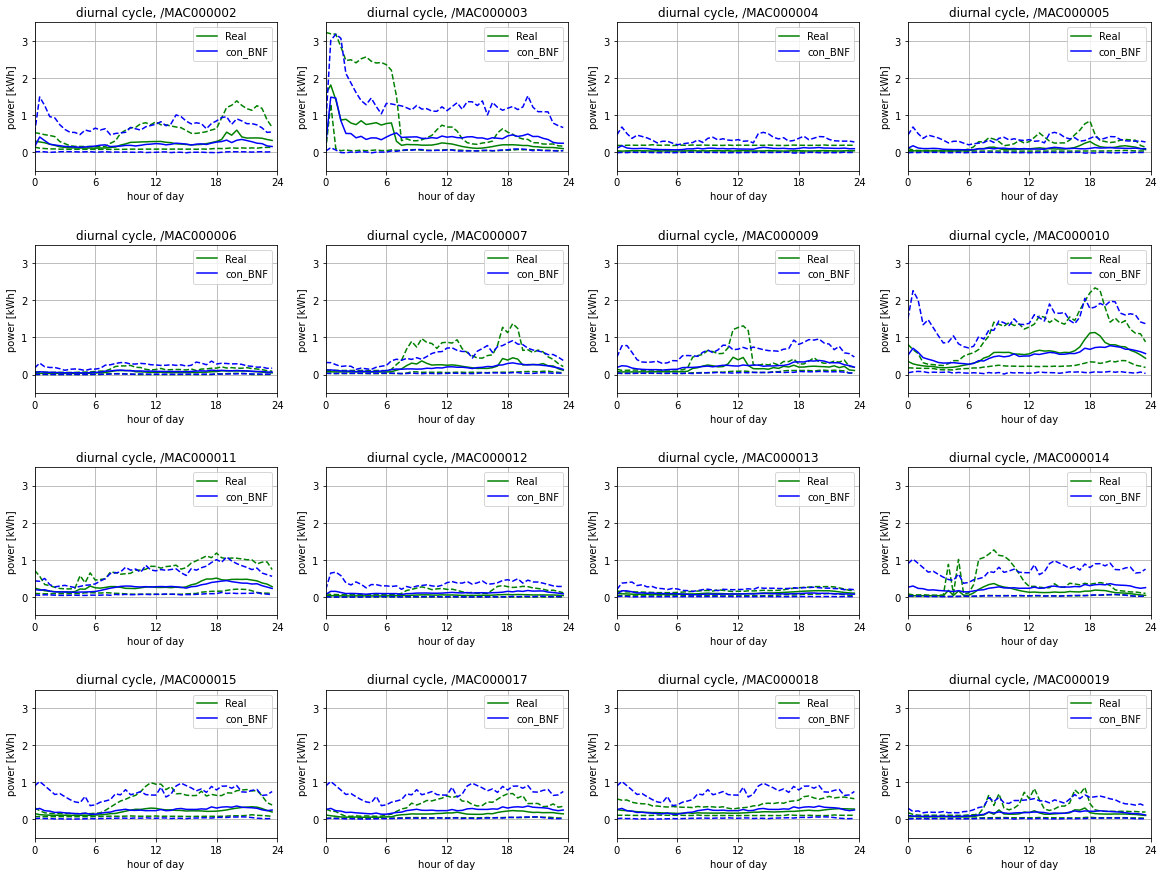

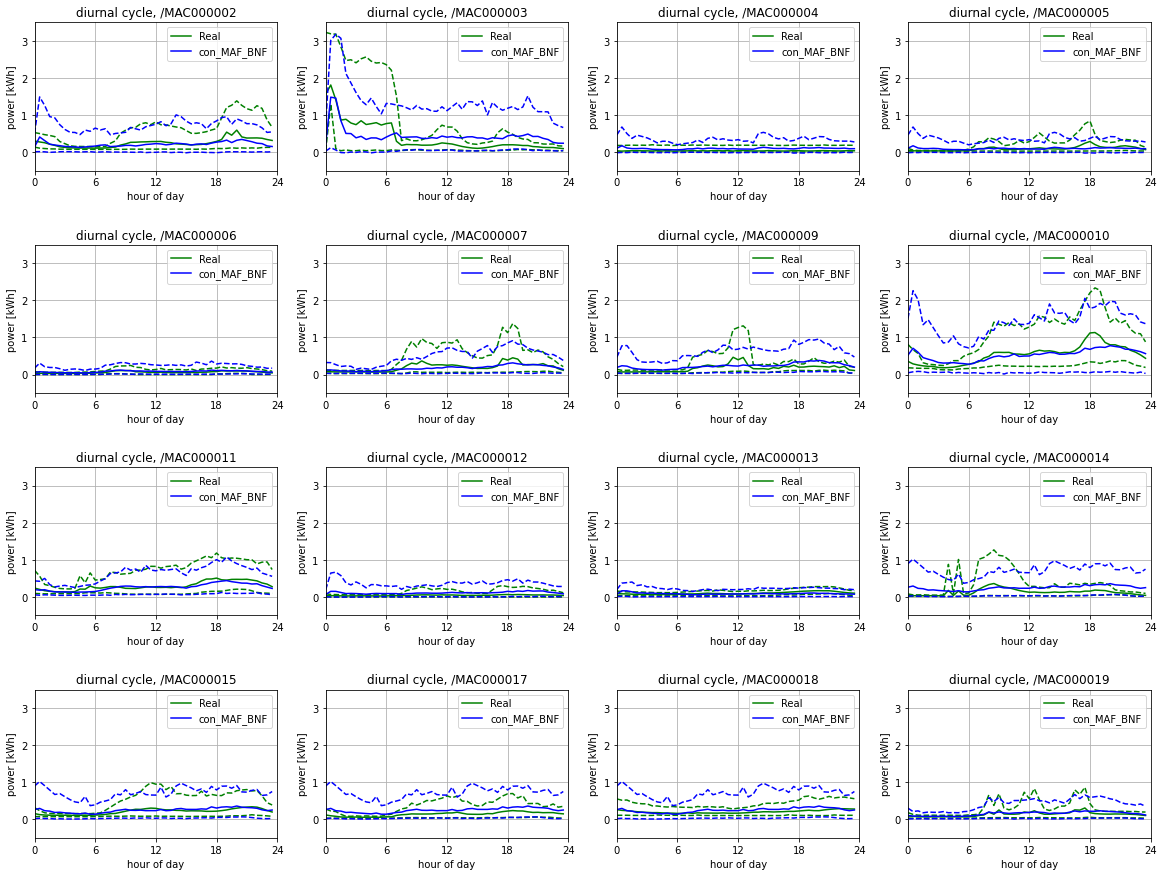

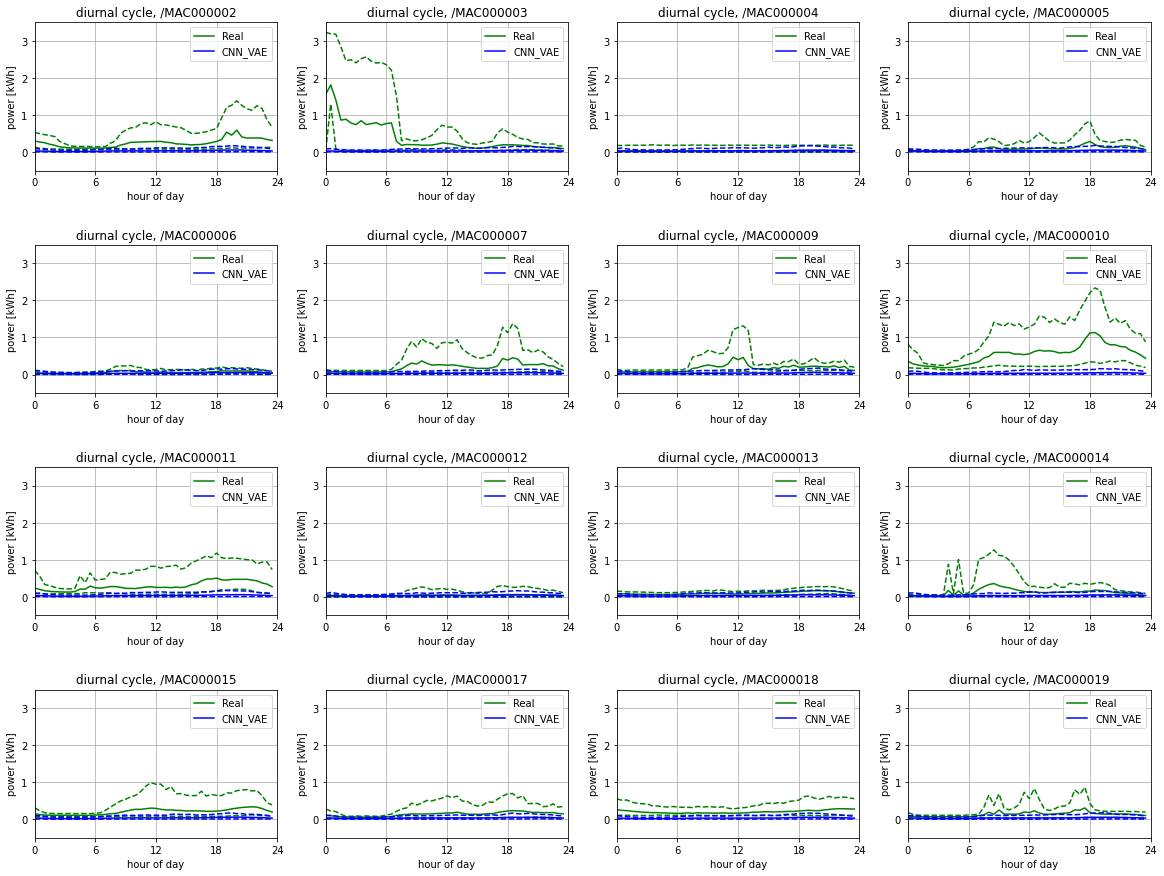

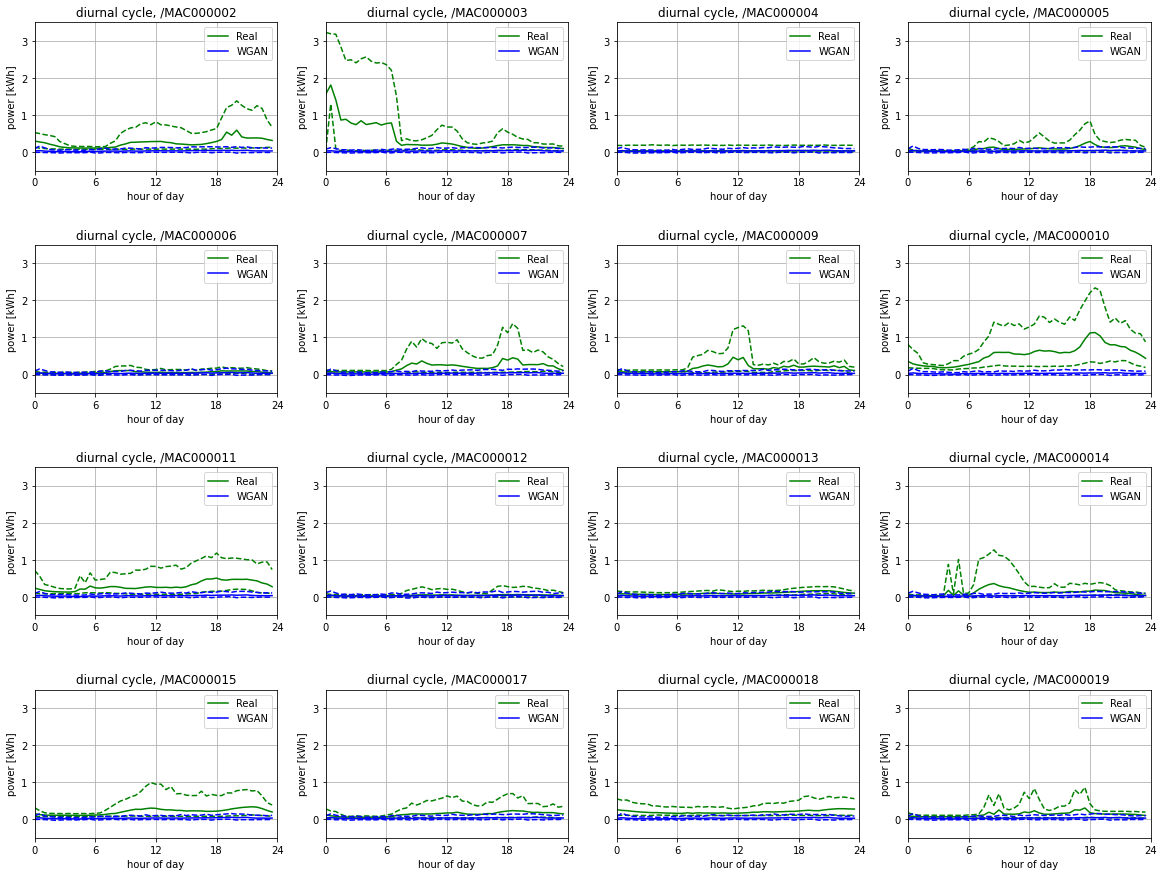

In [62]:
def diurnal_average_plot(data, samples, mdl_name):
  plt.figure(figsize=(20,15))

  for k, household in enumerate(data):
    if k>15:
      break
    time_test, power_test = household['time_test'], household['power_test']
    key = household['key']

    X_test = timeseries_to_day_matrix(time_test, power_test)

    time_fake = samples[key]['times']
    power_fake = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(time_fake, power_fake)

    mean_day_test = np.mean(X_test, axis=0)
    mean_day_mvn = np.mean(X_fake, axis=0)

    prctl_test = np.percentile(X_test, q=[5, 95], axis=0)
    prctl_mvn = np.percentile(X_fake, q=[5, 95], axis=0)

    hour = np.arange(0, 24, step=0.5)
    plt.subplot(4, 4, k+1)
    plt.plot(hour, mean_day_test, 'g', label='Real')
    plt.plot(hour, prctl_test.T, 'g--')
    plt.plot(hour, mean_day_mvn, 'b', label=mdl_name)
    plt.plot(hour, prctl_mvn.T, 'b--')
    plt.xticks([0,6,12,18,24])
    plt.legend()
    plt.xlabel('hour of day')
    plt.title(f'diurnal cycle, {key}')
    plt.ylabel('power [kWh]')
    plt.grid('on')
    plt.xlim([0, 24])
    plt.ylim([-.5, 3.5])
  plt.subplots_adjust(hspace=0.5)
  plt.show()

diurnal_average_plot(data, gmm_samples, mdl_name='GMM')
print("\n"*1)
diurnal_average_plot(data, mvn_samples, mdl_name='MVN')
print("\n"*1)
diurnal_average_plot(data, hmm_samples, mdl_name='HMM')
print("\n"*1)
diurnal_average_plot(data, ddpm_samples, mdl_name='DDPM')
print("\n"*1)
diurnal_average_plot(data, con_bnf_samples, mdl_name='con_BNF')
print("\n"*1)
diurnal_average_plot(data, con_bnf_samples2, mdl_name='con_MAF_BNF')
print("\n"*1)
diurnal_average_plot(data, CNN_VAE_samples, mdl_name='CNN_VAE')
print("\n"*1)
diurnal_average_plot(data, WGAN_samples, mdl_name='WGAN')

c:\Users\P\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


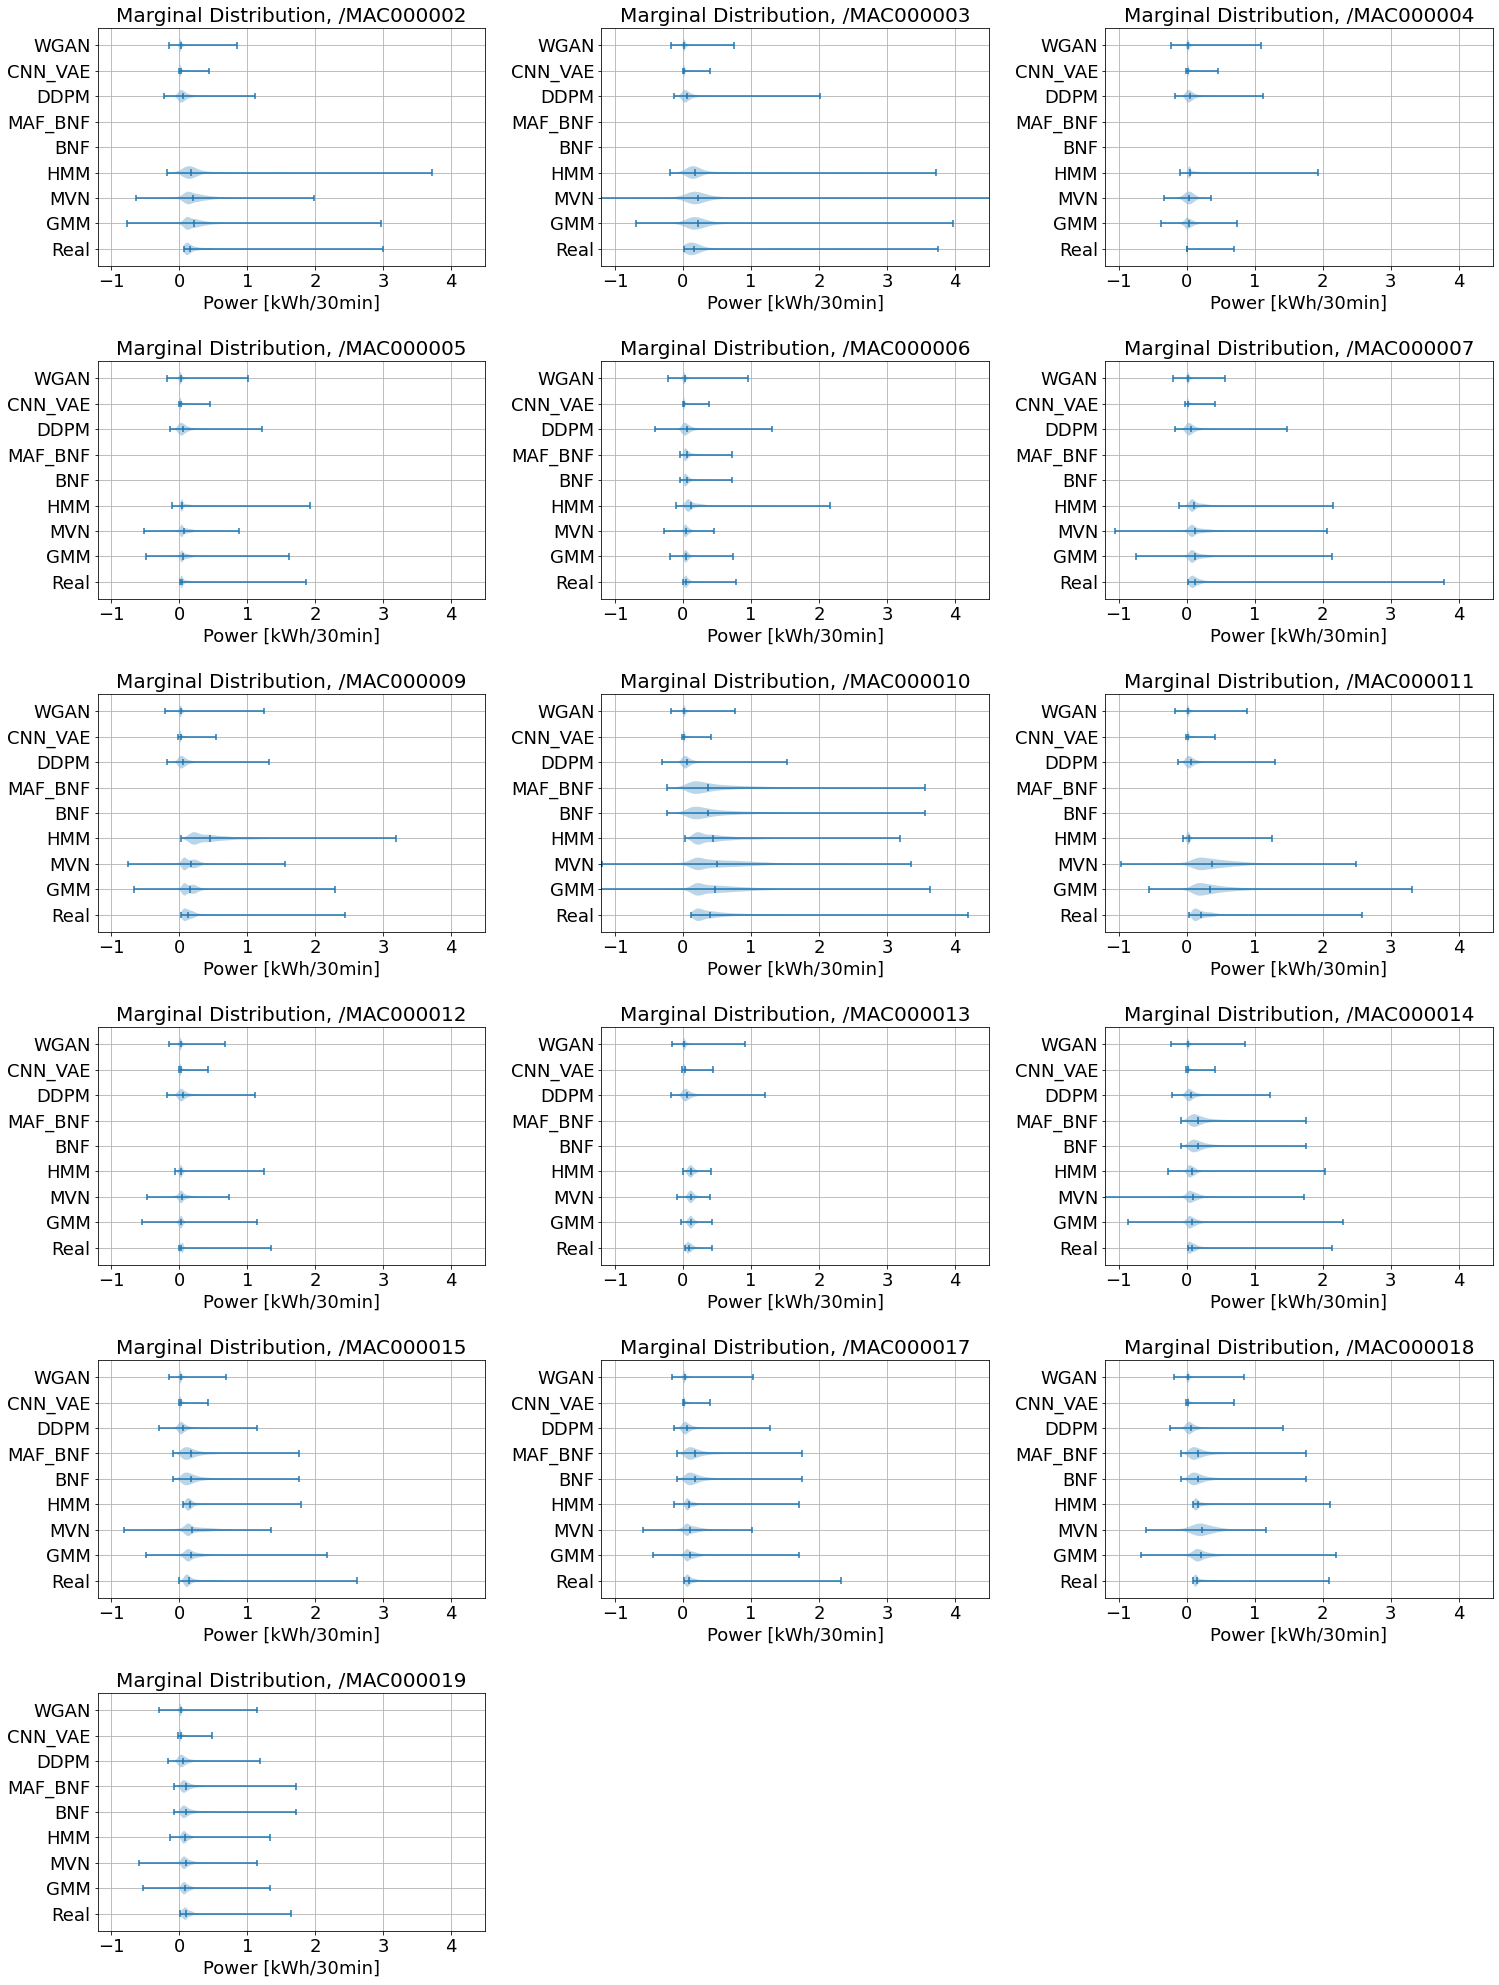

In [63]:

def marginal_dist_violinplots(data, **model_samples):
  plt.figure(figsize=(25,35))
  
  for k, household in enumerate(data):
    if k>=16:
      break
    plt.subplot(6, 3, k+1)
    key = household['key']
    data_list = [household['power_test']]
    label_list = ['Real']
    for mdl_name, samples in model_samples.items():
      data_list.append(samples[key]['samples'])
      label_list.append(mdl_name)
    plt.violinplot(data_list, 
                  showmeans=False, 
                  showmedians=True, 
                  showextrema=True, 
                  vert=False)
    plt.yticks([1, 2, 3, 4,5,6,7,8,9], label_list, rotation=0, fontsize=18)
    plt.xlabel('Power [kWh/30min]', fontsize=18)
    plt.xlim([-1.2, 4.5])
    plt.xticks(fontsize=18)
    plt.title(f'Marginal Distribution, {key}', fontsize=20)
    plt.grid('on')
  plt.subplots_adjust(hspace=0.4)
  plt.subplots_adjust(wspace=0.3)
  plt.show()


marginal_dist_violinplots(data, 
  GMM=gmm_samples, 
  MVN=mvn_samples,
  HMM=hmm_samples,
  BNF=con_bnf_samples,
  MAF_BNF=con_bnf_samples2,
  DDPM=ddpm_samples,
  CNN_VAE=CNN_VAE_samples,
  WGAN=WGAN_samples  
)

(4185,)
(4185, 48)


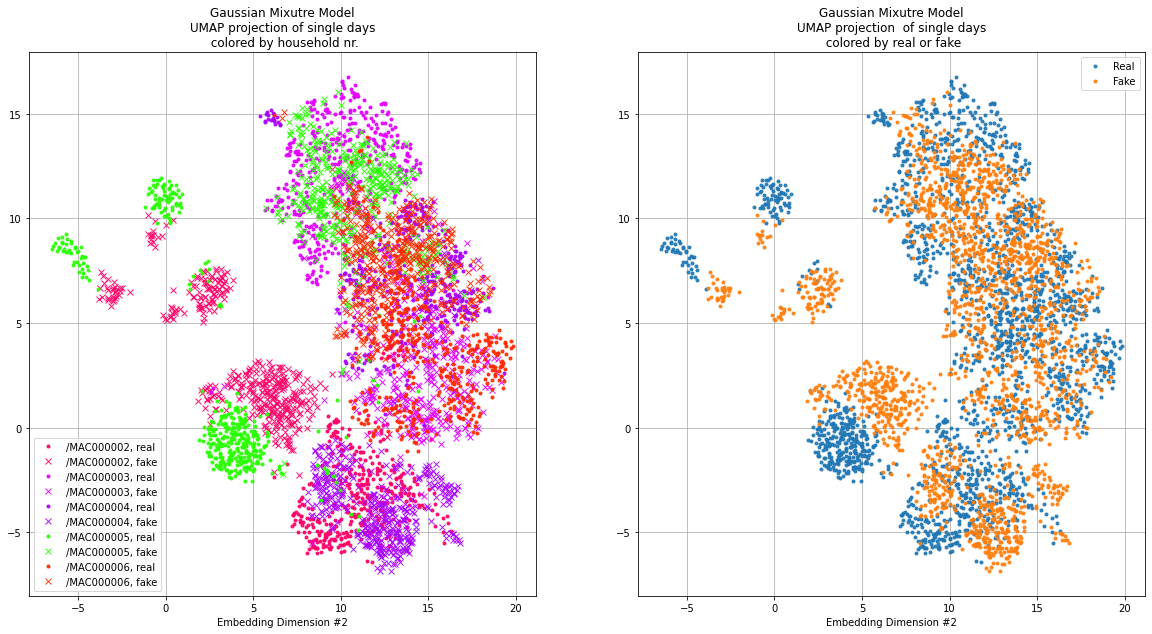

(4185,)
(4185, 48)


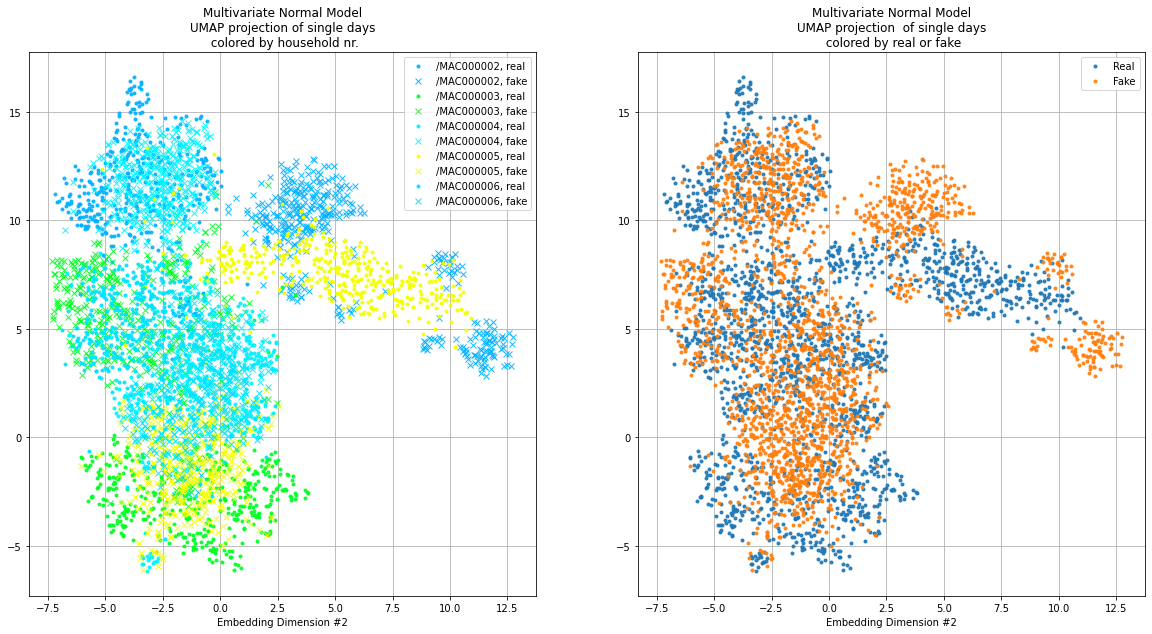

(4185,)
(4185, 48)


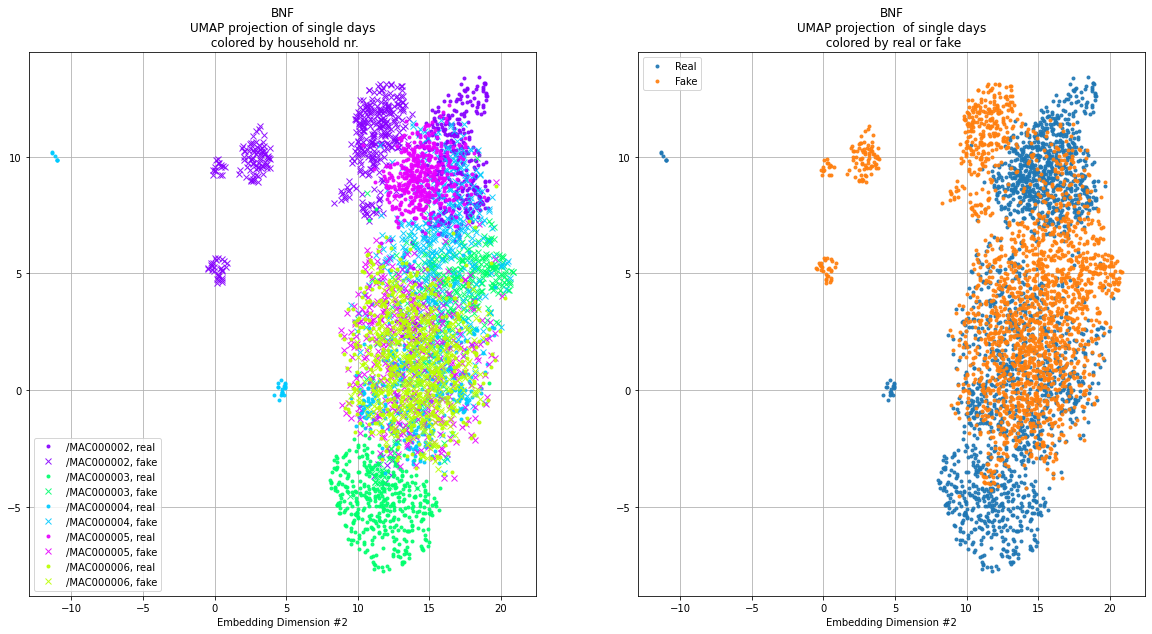

(4185,)
(4185, 48)


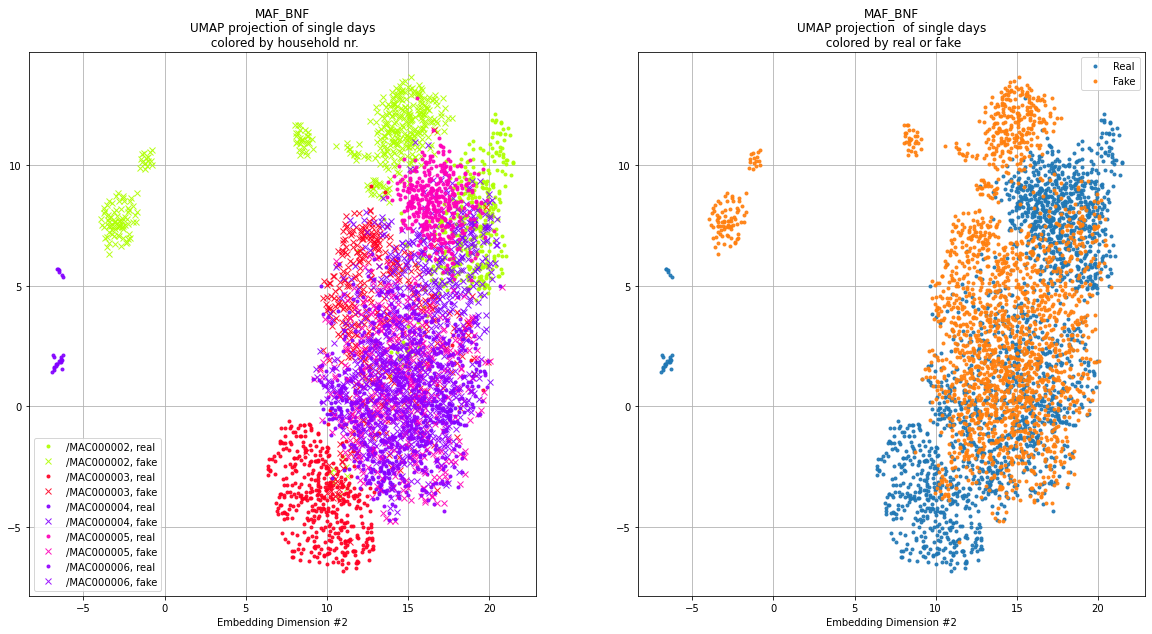

(3920,)
(3920, 48)


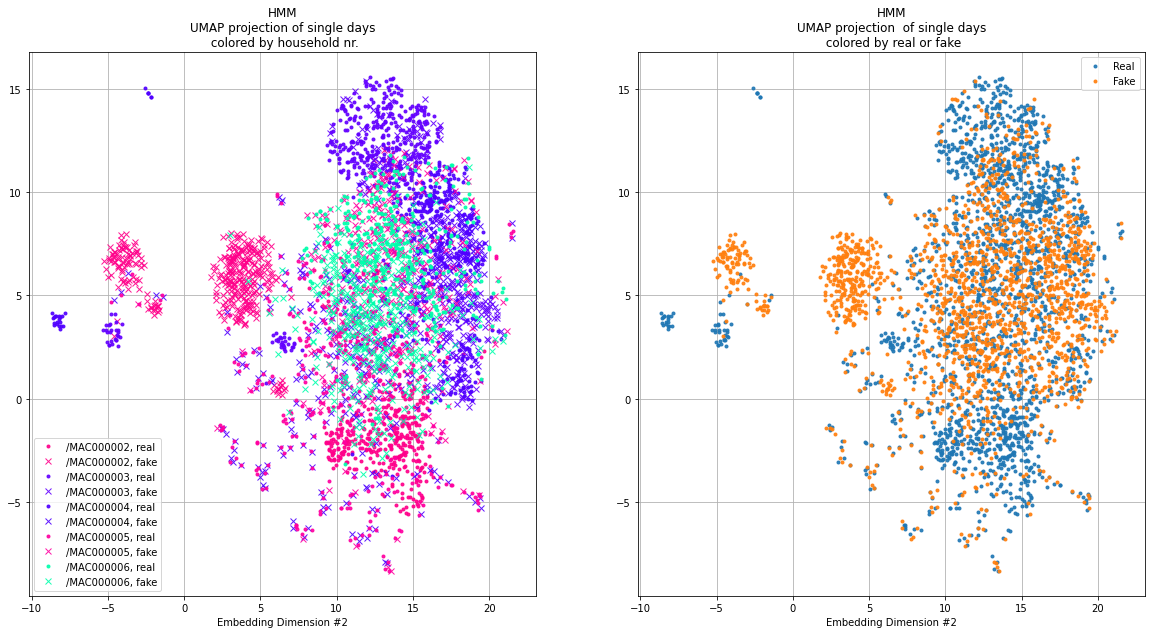

(4205,)
(4205, 48)


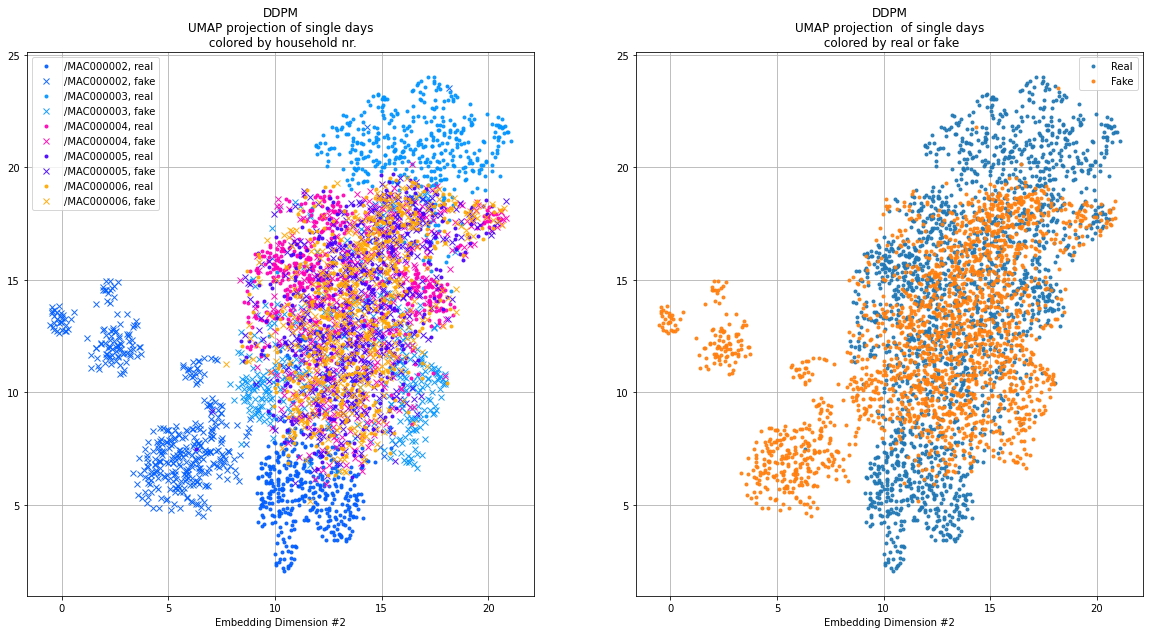

(4345,)
(4345, 48)


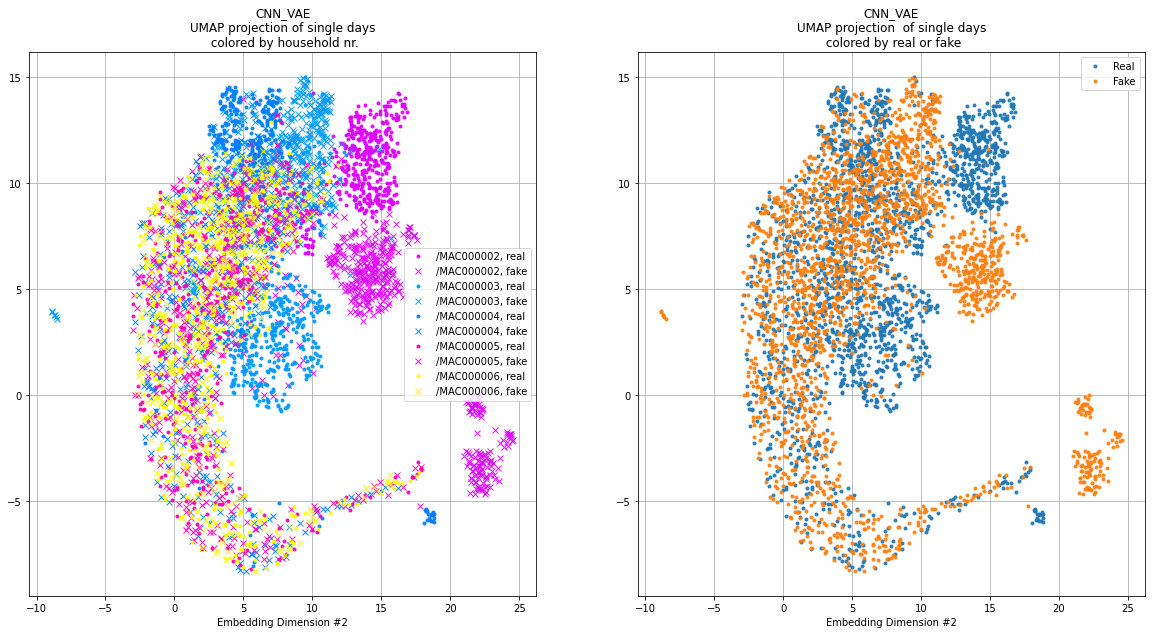

(4345,)
(4345, 48)


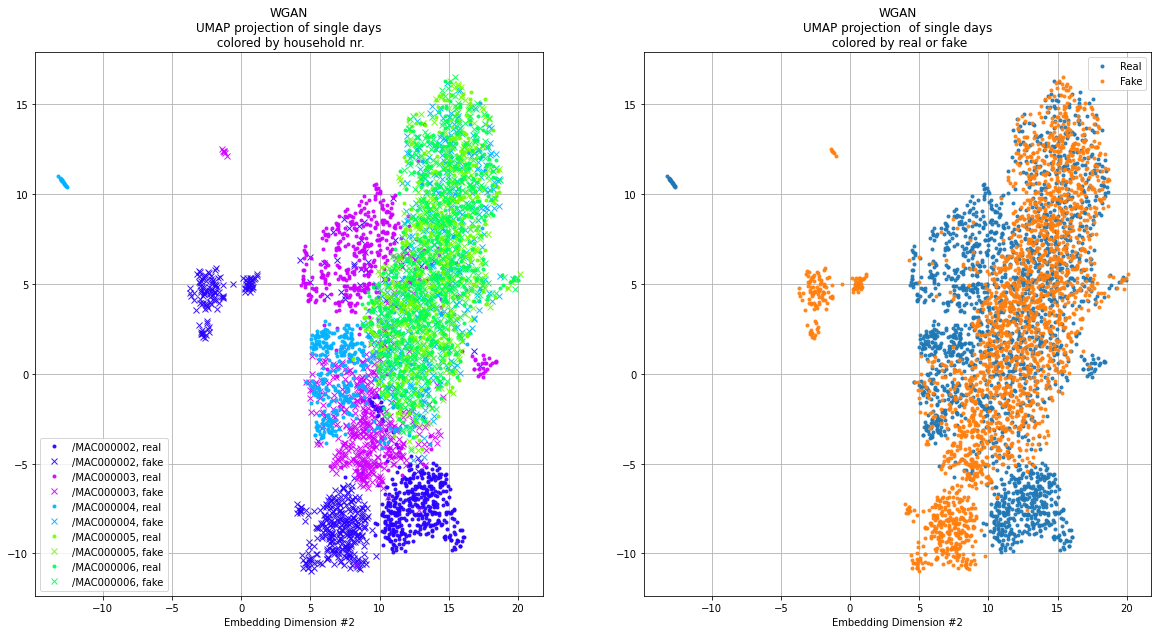

In [64]:

def umap_plots(data, samples, mdl_name, n_households=5):

  X_real_list = []
  X_fake_list = []

  id_list = []
  fake_flag = []
  key_list = []
  for k, household in enumerate(data):
    if k>=n_households:
      break
    real_time = household['time_test']
    real_power = household['power_test']
    key = household['key']

    key_list.append(key)

    X_real = timeseries_to_day_matrix(real_time, real_power)
    X_real_list.append(X_real)

    fake_time = samples[key]['times']
    fake_power = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(fake_time, fake_power)
    X_fake_list.append(X_fake)

    id = np.ones(X_real.shape[0] + X_fake.shape[0])*k
    id_list.append(id)

    fake = np.ones(X_real.shape[0] + X_fake.shape[0])
    fake[:X_real.shape[0]] = 0
    fake_flag.append(fake)
    

  id_list = np.concatenate(id_list)
  fake_flag = np.concatenate(fake_flag)

  X_real_all = np.concatenate(X_real_list, axis=0)
  X_fake_all = np.concatenate(X_fake_list, axis=0)

  X_all = np.concatenate([X_real_all, X_fake_all], axis=0);


  print(id_list.shape)
  print(X_all.shape)

  # standardize columns
  mean_all = np.mean(X_all, axis=0)
  std_all = np.std(X_all, axis=0)
  X_all = (X_all-mean_all)/std_all

  # Define UMAP parameters
  n_components = 2
  n_neighbors = 10
  min_dist = 1.

  # Create a UMAP model and fit the data
  umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
  umap_data = umap_model.fit_transform(X_all)

  # Plot the results
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  for k, key in enumerate(key_list):
    color = np.random.rand(3)
    color = (color-color.min())/(color.max()-color.min())
    fltr = np.logical_and(id_list==k, fake_flag==0)
    plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], '.', color=color, alpha=0.9, label=f'{key}, real')
    fltr = np.logical_and(id_list==k, fake_flag==1)
    plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], 'x', color=color, alpha=0.9, label=f'{key}, fake')
  plt.legend()

  #plt.scatter(umap_data[:, 0], umap_data[:, 1], c=id_list, s=10, alpha=0.9)
  plt.grid('on')
  plt.title(f"{mdl_name}\nUMAP projection of single days\n colored by household nr.")
  plt.xlabel('Embedding Dimension #1')
  plt.xlabel('Embedding Dimension #2')

  # Plot the results
  plt.subplot(1,2,2)
  #plt.scatter(umap_data[:, 0], umap_data[:, 1], c=fake_flag, s=10, alpha=0.9)
  plt.plot(umap_data[fake_flag==0, 0], umap_data[fake_flag==0, 1], '.', alpha=0.9, label='Real')
  plt.plot(umap_data[fake_flag==1, 0], umap_data[fake_flag==1, 1], '.', alpha=0.9, label='Fake')
  plt.grid('on')
  plt.legend()
  plt.title(f"{mdl_name}\nUMAP projection  of single days\n colored by real or fake")
  plt.xlabel('Embedding Dimension #1')
  plt.xlabel('Embedding Dimension #2')

  plt.show()

umap_plots(data, gmm_samples, mdl_name='Gaussian Mixutre Model')
umap_plots(data, mvn_samples, mdl_name='Multivariate Normal Model')
umap_plots(data, con_bnf_samples, mdl_name='BNF')
umap_plots(data, con_bnf_samples2, mdl_name='MAF_BNF')
umap_plots(data, hmm_samples, mdl_name='HMM')
umap_plots(data, ddpm_samples, mdl_name='DDPM')
umap_plots(data, CNN_VAE_samples, mdl_name='CNN_VAE')
umap_plots(data, WGAN_samples, mdl_name='WGAN')


(18855, 48)
(18855,)
(18855,)
(18855,)


'\numap_plots(data, \n  GMM=gmm_samples, \n  MVN=mvn_samples,\n  DDPM=ddpm_samples,\n  HMM=hmm_samples,\n  MAF_BNF=con_bnf_samples2,\n  BNF=con_bnf_samples,\n  VAE=CNN_VAE_samples,\n  WGAN=wgan_samples\n)\n'

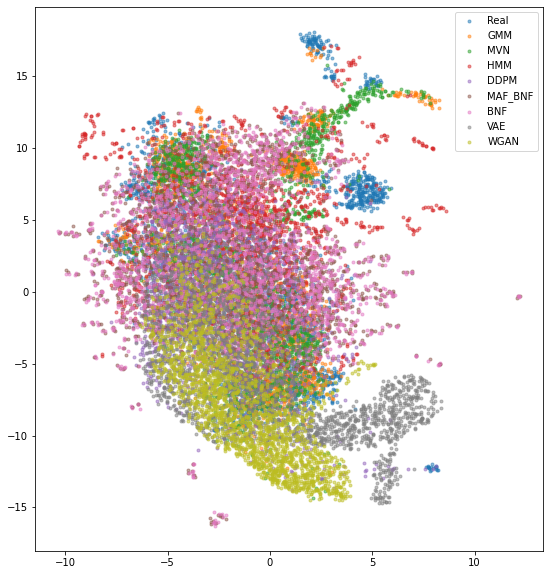

In [72]:
n_households=5
model_samples = dict(
  GMM=gmm_samples, 
  MVN=mvn_samples,
  HMM=hmm_samples,
  DDPM=ddpm_samples,
  MAF_BNF=con_bnf_samples2,
  BNF=con_bnf_samples,
  VAE=CNN_VAE_samples,
  WGAN=WGAN_samples
)
#def umap_plots(data, n_households=5, **model_samples):

X_list = []


household_id_list = []
fake_flag = []
key_list = []
mdl_list = []
mdl_names = ['Real']
mdl_ids = [-1]

for k, household in enumerate(data):
  if k>=n_households:
    break
  real_time = household['time_test']
  real_power = household['power_test']
  key = household['key']

  key_list.append(key)

  X_real = timeseries_to_day_matrix(real_time, real_power)
  X_list.append(X_real)

  household_id = np.ones(X_real.shape[0])*k
  household_id_list.append(household_id)
  fake = np.ones(X_real.shape[0])
  fake_flag.append(fake)
  mdl_list.extend([-1]*X_real.shape[0])
  for mdl_id, (mdl_name, samples) in enumerate(model_samples.items()):
    fake_time = samples[key]['times']
    fake_power = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(fake_time, fake_power)
    X_list.append(X_fake)

    household_id = np.ones(X_fake.shape[0])*k
    household_id_list.append(household_id)
    fake = np.zeros(X_fake.shape[0])
    fake_flag.append(fake)
    mdl_list.extend([mdl_id]*X_fake.shape[0])
    if k==0:
      mdl_ids.append(mdl_id)
      mdl_names.append(mdl_name)

household_id_list = np.concatenate(household_id_list)
fake_flag = np.concatenate(fake_flag)
mdl_list = np.array(mdl_list)

X_all = np.concatenate(X_list, axis=0)

print(X_all.shape)
print(mdl_list.shape)
print(fake_flag.shape)
print(household_id_list.shape)

# standardize columns
mean_all = np.mean(X_all, axis=0)
std_all = np.std(X_all, axis=0)
X_all = (X_all-mean_all)/std_all

# Define UMAP parameters
n_components = 2
n_neighbors = 10
min_dist = 1.

# Create a UMAP model and fit the data
umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
umap_data = umap_model.fit_transform(X_all)

# Plot the results
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
for k, (mdl_id, mdl_name) in enumerate(zip(mdl_ids, mdl_names)):
  fltr = mdl_list==mdl_id
  plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], '.', alpha=0.5, label=f'{mdl_name}')
plt.legend()

"""
umap_plots(data, 
  GMM=gmm_samples, 
  MVN=mvn_samples,
  DDPM=ddpm_samples,
  HMM=hmm_samples,
  MAF_BNF=con_bnf_samples2,
  BNF=con_bnf_samples,
  VAE=CNN_VAE_samples,
  WGAN=wgan_samples
)
"""

In [103]:
def plot_neighbors(umap_data, target_position, n = 5):
  target_position = np.array(target_position).reshape(1,2)
  idx_sort = np.argsort(np.sum(np.square(umap_data - target_position), axis=1))
  target_samples = X_all[idx_sort[:n]]
  target_mdls = mdl_list[idx_sort[:n]]

  color_list = ['k', 'r', 'b', 'orange']
  for ts, tmdls in zip(target_samples, target_mdls):
    plt.plot(np.arange(0, 24, 0.5), ts, color_list[tmdls+1], label=mdl_names[tmdls+1])
  plt.legend()
  plt.xlabel('Time of Day [h]')
  plt.ylabel('Power [kWh / 30min]')
  

plot_neighbors(umap_data, [0, 5], n = 5)
plt.show()

plot_neighbors(umap_data, [0, 0], n = 5)
plt.show()

IndexError: list index out of range

In [97]:
umap_data.shape

(18855, 2)

IndexError: list index out of range

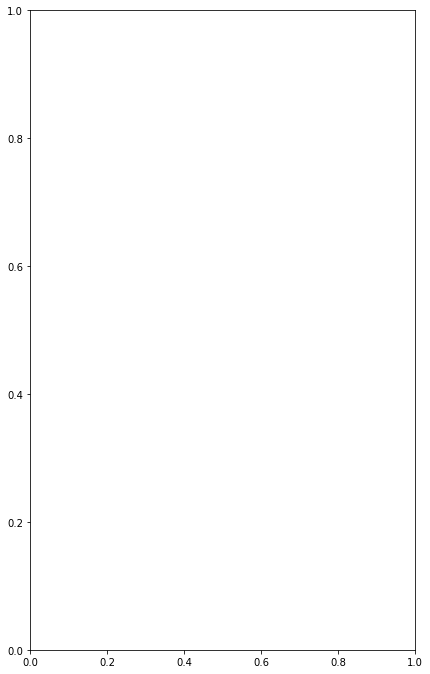

In [95]:
n_clusters = 15
kmeans_mdl = KMeans(n_clusters=n_clusters)
kmeans_mdl.fit(umap_data)
cluster_id = kmeans_mdl.predict(umap_data)

plt.figure(figsize=(40, 40))
for k, center in enumerate(kmeans_mdl.cluster_centers_):
  plt.subplot(3, 5, 14*k+1)
  plot_neighbors(umap_data, center, n = 10)

  plt.subplot(3, 5, 14*k+2)
  plt.scatter(umap_data[:,0], umap_data[:,1], c=cluster_id == k)
plt.subplots_adjust(hspace=0.5)

Ttest_indResult(statistic=-11.873886240216006, pvalue=2.329187830352607e-25)
Ttest_1sampResult(statistic=-6.84694085848035, pvalue=4.787385893119746e-10)


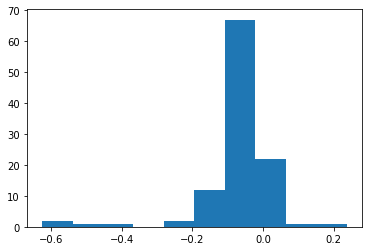

In [77]:
pairwise_differences = np.array(household_mmds['GaussianMixtureModel']) - np.array(household_mmds['HMM'])
plt.hist(pairwise_differences)



print(scipy.stats.ttest_ind(household_mmds['GaussianMixtureModel'], household_mmds['DDPM'], alternative='two-sided'))
print(scipy.stats.ttest_1samp(pairwise_differences.ravel(), 0, alternative='two-sided'))

In [76]:
test_results = scipy.stats.ttest_1samp(pairwise_differences.ravel(), 0, alternative='two-sided')
print(test_results)

Ttest_1sampResult(statistic=-6.84694085848035, pvalue=4.787385893119746e-10)
